In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn import plotting
from nilearn.image import new_img_like

In [2]:
import rsatoolbox
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed, Model
from rsatoolbox.rdm import RDMs
from rsatoolbox.vis import show_rdm, show_rdm_panel

from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from glob import glob

In [3]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [4]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'data_denoised/derivatives/',
                            'denoised_fmriprep-22.1.1/')

bidsroot = os.path.join(project_dir, 'data_denoised')
deriv_dir = os.path.join(bidsroot, 'derivatives')

fwhm_sub = 0
model_dir = os.path.join(deriv_dir, 'nilearn', 'level-1_fwhm-{:.02f}'.format(fwhm_sub),)

task_list = ['tonecat']
space_label = 'MNI152NLin2009cAsym'

In [5]:
statmap = 'tstat' # 'beta'

In [6]:
model_desc = 'stimulus_per_run_LSS'

In [7]:
model_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/derivatives/nilearn/level-1_fwhm-0.00'

## Make categorical models

In [8]:
pattern_descriptors = {'tone': ['T1', 'T1', 'T1', 'T1', 
                                'T2', 'T2', 'T2', 'T2', 
                                'T3', 'T3', 'T3', 'T3', 
                                'T4', 'T4', 'T4', 'T4', ],
                       'talker': ['M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2',
                                  'M1', 'M2', 'F1', 'F2', ],
                      }
                                  

### Categorical RDMs

In [9]:
# make categorical RDMs
tone_rdm = np.array([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,],
                     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,], ])

talker_rdm = np.array([[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ],
                       [0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, ],
                       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ],
                       [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, ],
                       [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, ], ])

rdms_array = np.array([tone_rdm, talker_rdm])

In [10]:
cat_rdms = RDMs(rdms_array,
                  rdm_descriptors={'categorical_model':['tone', 'talker'],},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                 )

In [11]:
tone_rdms = cat_rdms.subset('categorical_model','tone')

talker_rdms = cat_rdms.subset('categorical_model','talker')

#### Convert from RDM to Model

In [12]:
tone_model = ModelFixed( 'Tone', cat_rdms.subset('categorical_model', 'tone'))
talker_model = ModelFixed( 'Talker', cat_rdms.subset('categorical_model', 'talker'))
cat_models = [tone_model, talker_model]

In [13]:
tone_model.name

'Tone'

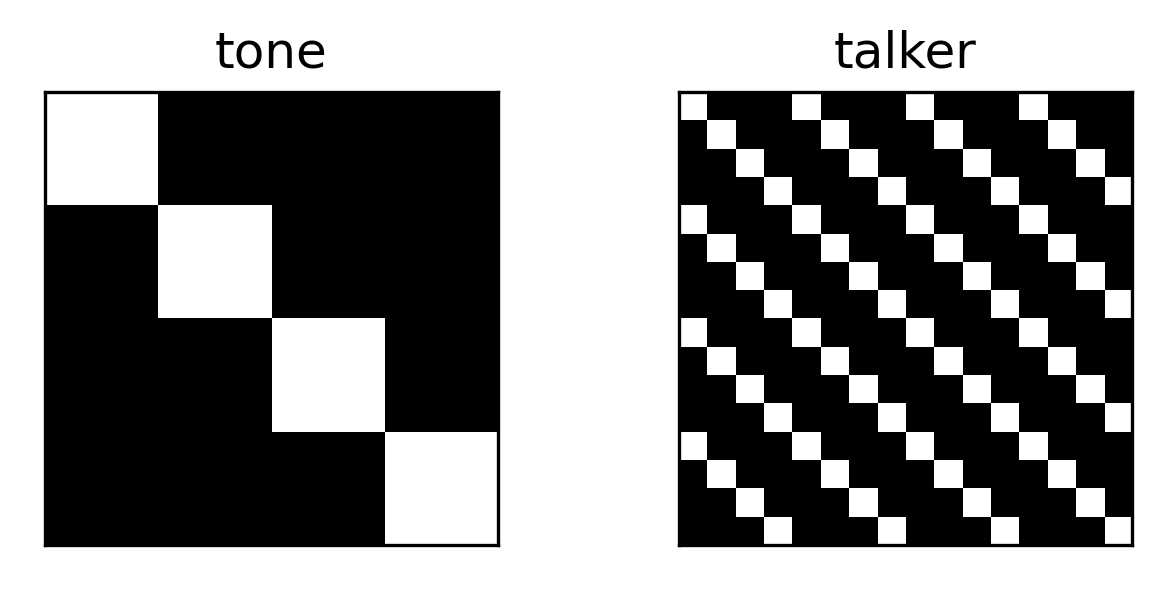

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(5,2), dpi=300)

#show_rdm_panel(ffr_rdm, ax=axs.flat[0], rdm_descriptor='FFR model', cmap='inferno',)
show_rdm_panel(tone_rdms, ax=axs.flat[0], rdm_descriptor='categorical_model', cmap='Greys',)
show_rdm_panel(talker_rdms, ax=axs.flat[1], rdm_descriptor='categorical_model', cmap='Greys',)


## Set up participants

In [15]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27', # always leave out FLT27 – did not participate
               'sub-FLT07', # bad QA 11/14/23 
               # 'sub-FLT02', # incorrect button press coding for run00
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [16]:
participants_df

,participant_id,age,sex,group,FFR_id
0,sub-FLT02,21,F,non-Mandarin,1002.0
1,sub-FLT03,25,F,Mandarin,2002.0
2,sub-FLT04,21,F,non-Mandarin,1003.0
3,sub-FLT05,26,M,Mandarin,3010.0
4,sub-FLT06,21,F,non-Mandarin,3001.0
5,sub-FLT08,23,F,Mandarin,2005.0
6,sub-FLT09,30,F,non-Mandarin,3002.0
7,sub-FLT10,23,F,Mandarin,2006.0
8,sub-FLT11,20,F,non-Mandarin,1005.0
9,sub-FLT12,20,F,non-Mandarin,3004.0


In [17]:
# create group-specific lists of subject IDs
sub_group_dict = {'Mandarin': list(participants_df.participant_id[participants_df.group=='Mandarin']),
                  'non-Mandarin': list(participants_df.participant_id[participants_df.group=='non-Mandarin'])}

In [18]:
sub_group_dict

{'Mandarin': ['sub-FLT03',
  'sub-FLT05',
  'sub-FLT08',
  'sub-FLT10',
  'sub-FLT15',
  'sub-FLT17',
  'sub-FLT18',
  'sub-FLT19',
  'sub-FLT21',
  'sub-FLT22',
  'sub-FLT23',
  'sub-FLT24',
  'sub-FLT26'],
 'non-Mandarin': ['sub-FLT02',
  'sub-FLT04',
  'sub-FLT06',
  'sub-FLT09',
  'sub-FLT11',
  'sub-FLT12',
  'sub-FLT13',
  'sub-FLT14',
  'sub-FLT20',
  'sub-FLT25',
  'sub-FLT28',
  'sub-FLT30']}

In [19]:
participant_list = participants_df.participant_id
participant_list = [p.split('-')[1] for p in participant_list]
group_assignment = participants_df.group

# Run with auditory cortical ROIs

## Define network ROIs

In [20]:
## define ROIs
network_name = 'auditory' # 'tian_subcortical_S3' # auditory

if network_name == 'auditory':
    roi_list_ordered = [
                #'L-IC', 'L-MGN', 
                'L-HG', 'L-PT',  'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri',
                #'R-IC', 'R-MGN', 
                'R-HG', 'R-PT',  'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 
               ]
elif network_name == 'aud-striatal':
    roi_list_ordered = ['L-Caud', 'L-Put', 'L-IC', 'L-MGN',
                'L-HG', 'L-PP', 'L-PT', 'L-STGa', 'L-STGp', 
                'L-ParsOp', 'L-ParsTri',
                'R-Caud', 'R-Put','R-IC', 'R-MGN',
                'R-HG', 'R-PP', 'R-PT', 'R-STGa', 'R-STGp', 
                'R-ParsOp', 'R-ParsTri',
               ]
elif network_name == 'tian_subcortical_S3':
    roi_list_ordered = [
        'CAU-DA-lh', 'CAU-DA-rh', 
        'CAU-VA-lh', 'CAU-VA-rh', 
        'pCAU-lh', 'pCAU-rh', 
        'PUT-DA-lh', 'PUT-DA-rh', 
        'PUT-DP-lh', 'PUT-DP-rh', 
        'PUT-VA-lh', 'PUT-VA-rh', 
        'PUT-VP-lh', 'PUT-VP-rh',
        #'aGP-lh', 'pGP-lh', 
        #'NAc-core-lh',  'NAc-core-rh', 
        #'NAc-shell-lh', 'NAc-shell-rh', 
         #'aGP-rh', 'pGP-rh',         
               ]
    


## Load run-specific subject-specific RDMs

In [21]:
# from `rsa_roi.py`-generated outputs
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    out_dir = os.path.join(model_dir, 'rsa_roi', network_name)
    sub_fpath = os.path.join(out_dir,
                         f'sub-{sub_id}_{network_name}_{model_desc}_rdms.hdf5')
    sub_rdm = rsatoolbox.rdm.rdms.load_rdm(sub_fpath)
    
    # add the group descriptor to the subject's RDM
    sub_rdm.rdm_descriptors['group'] = [group_id for x in sub_rdm.rdm_descriptors['index']]
    group_rdm_list.append(sub_rdm)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

FLT02
FLT03
FLT04
FLT05
FLT06
FLT08
FLT09
FLT10
FLT11
FLT12
FLT13
FLT14
FLT15
FLT17
FLT18
FLT19
FLT20
FLT21
FLT22
FLT23
FLT24
FLT25
FLT26
FLT28
FLT30


In [22]:
sub_rdm

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[2.70958132 1.91315956 0.55776532 ... 4.33697203 3.35463678 3.33869325]
 [1.30662205 1.17981053 0.7805125  ... 3.45529965 5.47064595 3.1937633 ]
 [1.6917238  2.23340903 1.50946295 ... 1.95276037 1.8822908  1.99994767]
 ...
 [2.54164648 2.13580177 2.39986088 ... 1.76201784 3.0123084  1.68025652]
 [2.26798675 2.27907055 2.49712192 ... 1.91833142 3.87014613 2.31061261]
 [1.96808046 2.98654485 2.15335233 ... 2.00335449 3.76090243 2.09767888]]
descriptors = 
{}
rdm_descriptors = 
{'ROI': ['L-IC', 'L-MGN', 'L-HG', 'L-PT', 'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri', 'R-IC', 'R-MGN', 'R-HG', 'R-PT', 'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 'L-IC', 'L-MGN', 'L-HG', 'L-PT', 'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri', 'R-IC', 'R-MGN', 'R-HG', 'R-PT', 'R-PP', 'R-STGp', 'R-STGa', 'R-ParsOp', 'R-ParsTri', 'L-IC', 'L-MGN', 'L-HG', 'L-PT', 'L-PP', 'L-STGp', 'L-STGa', 'L-ParsOp', 'L-ParsTri', 'R-IC', 'R

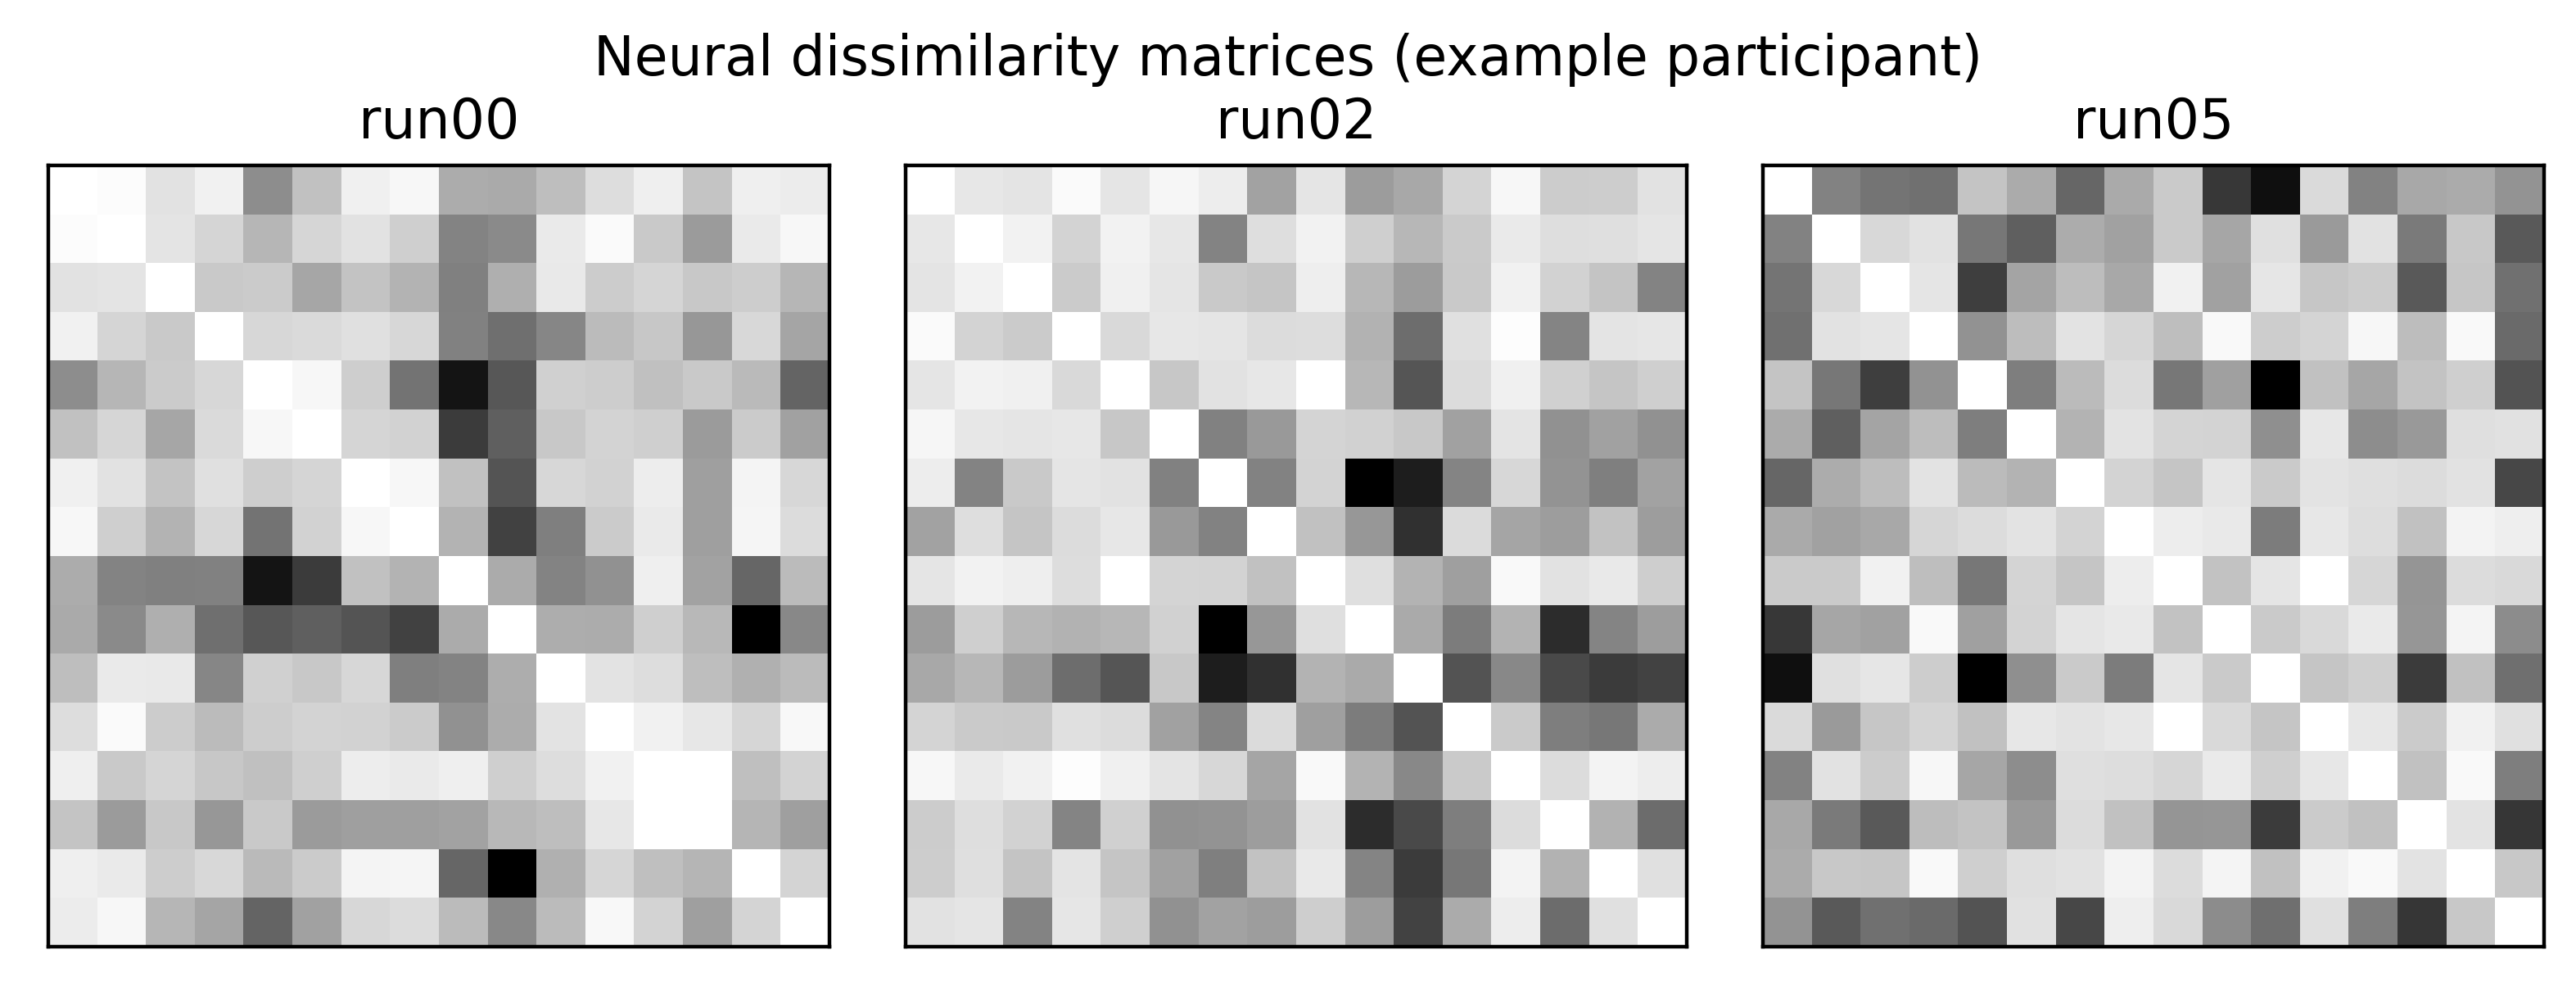

In [23]:
fig,ax = plt.subplots(1,3, figsize=(8,3), dpi=400)
fig.suptitle('Neural dissimilarity matrices (example participant)')

roi_ex = 'L-STGp'
for rx, run in enumerate([0, 2, 5]):    
    rdm_ex = sub_rdm.subset('ROI', value='L-STGp').subset('run', value='run0'+str(run))
    
    show_rdm_panel(rdm_ex, ax=ax[rx], rdm_descriptor='categorical_model', cmap='Greys',)
    ax[rx].set_title('run0'+str(run))
    ax[rx].tick_params(labelsize=6)

fig.tight_layout()

### Per "stage" (runcombo), per subject

In [24]:
runcombo_dict = {'early': ['run00', 'run01'], 
                 'middle': ['run02', 'run03'], 
                 'final': ['run04','run05']}

#### Load run-specific subject-specific behavioral confusion matrices

In [25]:
'''
beh_mat_dict = {}
for sx, sub_id in enumerate(participant_list): 
    print(sub_id)
    group_id = group_assignment[sx]
    
    sub_beh_dir = os.path.join(deriv_dir, 'behavior', f'sub-{sub_id}')
    
    sub_cm_dict = {}
    sub_cm_list = []
    for rx, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'sub-{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))
        
        sub_cm_dict[run] = sub_run_stim_cm
        sub_cm_list.append(sub_run_stim_cm)
        
    beh_mat_dict[sub_id] = sub_cm_dict
'''

"\nbeh_mat_dict = {}\nfor sx, sub_id in enumerate(participant_list): \n    print(sub_id)\n    group_id = group_assignment[sx]\n    \n    sub_beh_dir = os.path.join(deriv_dir, 'behavior', f'sub-{sub_id}')\n    \n    sub_cm_dict = {}\n    sub_cm_list = []\n    for rx, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):\n        sub_run_stim_cm = np.genfromtxt(os.path.join(sub_beh_dir, f'sub-{sub_id}_run-0{rx+1}_stimulus_confusion_matrix.tsv'))\n        \n        sub_cm_dict[run] = sub_run_stim_cm\n        sub_cm_list.append(sub_run_stim_cm)\n        \n    beh_mat_dict[sub_id] = sub_cm_dict\n"

#### Combine early, middle, and final run behavior RDMs

In [26]:
'''
stage_beh_mat_dict = {}
for sub_id in beh_mat_dict:
    print(sub_id)
    
    sub_dict = {}
    sub_early_mat = np.mean(np.array([beh_mat_dict[sub_id]['run00'], beh_mat_dict[sub_id]['run01']]), axis=0)
    sub_middle_mat = np.mean(np.array([beh_mat_dict[sub_id]['run02'], beh_mat_dict[sub_id]['run03']]), axis=0)
    sub_final_mat = np.mean(np.array([beh_mat_dict[sub_id]['run04'], beh_mat_dict[sub_id]['run05']]), axis=0)
    
    sub_dict['early'] = sub_early_mat
    sub_dict['middle'] = sub_middle_mat
    sub_dict['final'] = sub_final_mat
    
    stage_beh_mat_dict[sub_id] = sub_dict
'''

"\nstage_beh_mat_dict = {}\nfor sub_id in beh_mat_dict:\n    print(sub_id)\n    \n    sub_dict = {}\n    sub_early_mat = np.mean(np.array([beh_mat_dict[sub_id]['run00'], beh_mat_dict[sub_id]['run01']]), axis=0)\n    sub_middle_mat = np.mean(np.array([beh_mat_dict[sub_id]['run02'], beh_mat_dict[sub_id]['run03']]), axis=0)\n    sub_final_mat = np.mean(np.array([beh_mat_dict[sub_id]['run04'], beh_mat_dict[sub_id]['run05']]), axis=0)\n    \n    sub_dict['early'] = sub_early_mat\n    sub_dict['middle'] = sub_middle_mat\n    sub_dict['final'] = sub_final_mat\n    \n    stage_beh_mat_dict[sub_id] = sub_dict\n"

### Participant-specific across-model comparisons

In [27]:
group_dict = {}

for group_id in np.unique(group_rdms.rdm_descriptors['group']):

    for full_sub_id in sub_group_dict[group_id]:
        sub_id = full_sub_id[4:]
        try:
            ffr_id = str(int(participants_df[participants_df['participant_id'] == full_sub_id]['FFR_id'].values[0]))
            print(f'{sub_id} | ffr_id: {ffr_id}')
        except ValueError:
            print(f'no ffr_id for {sub_id}')
            continue

        sub_dict = {}

        for runcombo in runcombo_dict:
            # initialize results list
            runcombo_roi_res_dict = {}
            
            '''
            # create beh model from confusion matrix
            beh_mat = stage_beh_mat_dict[sub_id][runcombo]
            beh_dis_mat = beh_mat * -1 +1
        
            beh_rdm = RDMs(np.array([beh_dis_mat],))
            beh_model = ModelFixed('Behavior', rdm=beh_rdm)
            
            # combine all four models to run concurrently
            all_models = [tone_model, talker_model, beh_model]
            '''

            for ROI in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
                print(f'{sub_id} runcombo-{runcombo} ROI-{ROI}')
                runs = runcombo_dict[runcombo]

                results_grr = rsatoolbox.inference.eval_fixed(cat_models, #all_models, 
                                                              group_rdms.subset('participant', value=sub_id).subset('run',value=runs).subset('ROI',value=ROI),  
                                                              method='corr',)
                #print(f'p-value vs. 0: {results_grr.test_zero()[0]:.04f}')
                runcombo_roi_res_dict[ROI] = results_grr.get_means()#[0]
                #runcombo_roi_res_dict[ROI] = results_grr

            sub_dict[runcombo] = runcombo_roi_res_dict

        #except:
        #    print(f'no FFR data for {sub_id}')
        group_dict[sub_id] = sub_dict

FLT03 | ffr_id: 2002
FLT03 runcombo-early ROI-L-HG
FLT03 runcombo-early ROI-L-PT
FLT03 runcombo-early ROI-L-PP
FLT03 runcombo-early ROI-L-STGp
FLT03 runcombo-early ROI-L-STGa
FLT03 runcombo-early ROI-L-ParsOp
FLT03 runcombo-early ROI-L-ParsTri
FLT03 runcombo-early ROI-R-HG
FLT03 runcombo-early ROI-R-PT
FLT03 runcombo-early ROI-R-PP
FLT03 runcombo-early ROI-R-STGp
FLT03 runcombo-early ROI-R-STGa
FLT03 runcombo-early ROI-R-ParsOp
FLT03 runcombo-early ROI-R-ParsTri
FLT03 runcombo-middle ROI-L-HG
FLT03 runcombo-middle ROI-L-PT
FLT03 runcombo-middle ROI-L-PP
FLT03 runcombo-middle ROI-L-STGp
FLT03 runcombo-middle ROI-L-STGa
FLT03 runcombo-middle ROI-L-ParsOp
FLT03 runcombo-middle ROI-L-ParsTri
FLT03 runcombo-middle ROI-R-HG
FLT03 runcombo-middle ROI-R-PT
FLT03 runcombo-middle ROI-R-PP
FLT03 runcombo-middle ROI-R-STGp
FLT03 runcombo-middle ROI-R-STGa
FLT03 runcombo-middle ROI-R-ParsOp
FLT03 runcombo-middle ROI-R-ParsTri
FLT03 runcombo-final ROI-L-HG
FLT03 runcombo-final ROI-L-PT
FLT03 runcomb

In [28]:
print(results_grr)

Results for running fixed evaluation for corr on 2 models:

Model  |   Eval ± SEM   | p (against 0) | p (against NC) |
----------------------------------------------------------
Tone   |  0.008 ± 0.022 |        0.394  |         0.193  |
Talker | -0.055 ± 0.040 |        0.799  |         0.185  |

p-values are based on uncorrected t-tests


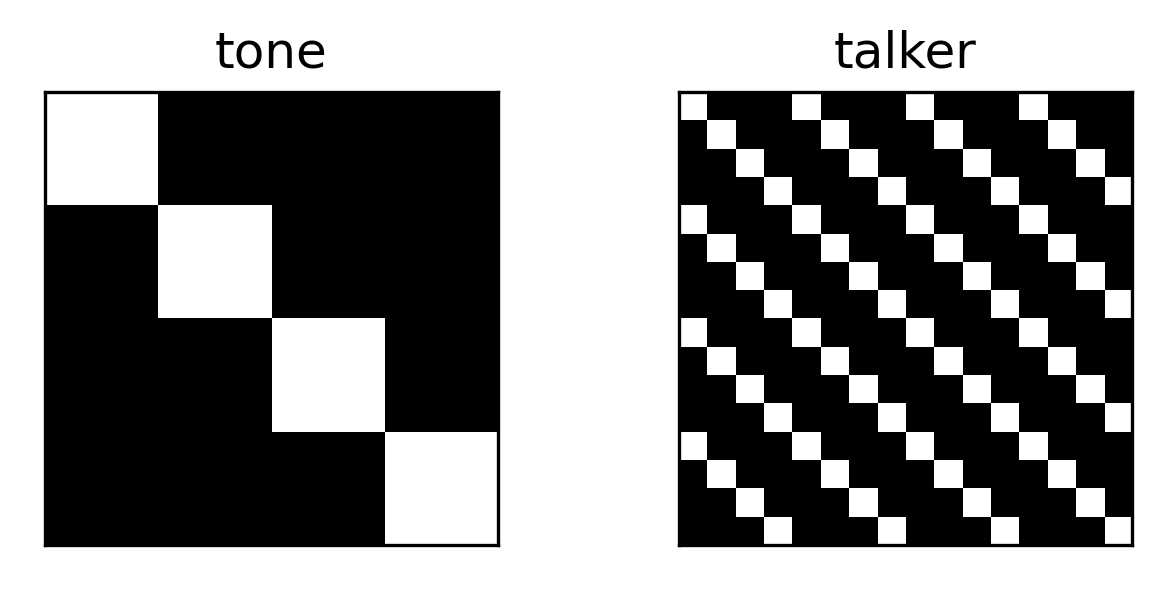

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(5,2), dpi=300)

#show_rdm_panel(ffr_rdm, ax=axs.flat[0], rdm_descriptor='FFR model', cmap='inferno',)
show_rdm_panel(tone_rdms, ax=axs.flat[0], rdm_descriptor='categorical_model', cmap='Greys',)
show_rdm_panel(talker_rdms, ax=axs.flat[1], rdm_descriptor='categorical_model', cmap='Greys',)


In [30]:
'''
fig,ax = plt.subplots(1,3, figsize=(8,3), dpi=400)
fig.suptitle('Behavior model by learning stage (example participant)')

for rx, runcombo in enumerate(runcombo_dict):    
    
    # create beh model from confusion matrix
    beh_mat = stage_beh_mat_dict[sub_id][runcombo]
    beh_dis_mat = beh_mat * -1 +1

    beh_rdm = RDMs(np.array([beh_dis_mat],))
    beh_model = ModelFixed('Behavior', rdm=beh_rdm)

    show_rdm_panel(beh_rdm, ax=ax[rx], rdm_descriptor='categorical_model', cmap='Greys',)
    ax[rx].set_title(runcombo)
    ax[rx].tick_params(labelsize=6)

fig.tight_layout()
'''

"\nfig,ax = plt.subplots(1,3, figsize=(8,3), dpi=400)\nfig.suptitle('Behavior model by learning stage (example participant)')\n\nfor rx, runcombo in enumerate(runcombo_dict):    \n    \n    # create beh model from confusion matrix\n    beh_mat = stage_beh_mat_dict[sub_id][runcombo]\n    beh_dis_mat = beh_mat * -1 +1\n\n    beh_rdm = RDMs(np.array([beh_dis_mat],))\n    beh_model = ModelFixed('Behavior', rdm=beh_rdm)\n\n    show_rdm_panel(beh_rdm, ax=ax[rx], rdm_descriptor='categorical_model', cmap='Greys',)\n    ax[rx].set_title(runcombo)\n    ax[rx].tick_params(labelsize=6)\n\nfig.tight_layout()\n"

#### Make dataframe

In [31]:
group_df_list = []
for group_id in np.unique(group_rdms.rdm_descriptors['group']):
    print(group_id)
    sub_df_list = []
    
    for full_sub_id in sub_group_dict[group_id]:
        try:
            sub_id = full_sub_id[4:]

            sub_df = pd.DataFrame.from_dict(group_dict[sub_id])
            sub_df['sub_id'] = sub_id
            sub_df_list.append(sub_df)
        except KeyError:
            print(f'not available for {full_sub_id}')

    group_df = pd.concat(sub_df_list)
    group_df.reset_index(inplace=True)
    long_group_df = group_df.melt(value_vars=['early','middle','final'], id_vars='index', value_name='corr', var_name='stage', ignore_index=False)
    long_group_df['participant_group'] = group_id
    long_group_df.rename(columns={"index": "ROI"}, inplace=True)
    
    group_df_list.append(long_group_df)

long_df = pd.concat(group_df_list)

Mandarin
not available for sub-FLT17
not available for sub-FLT26
non-Mandarin
not available for sub-FLT28
not available for sub-FLT30


In [32]:
# get model names for the models in the RSA operation
model_names = [x.name for x in results_grr.models]
print(model_names)

['Tone', 'Talker']


In [33]:
# split the results arrays into single-element columns by model
long_df[model_names] = long_df['corr'].to_list()
long_df.drop('corr', axis='columns', inplace=True) 

In [34]:
long_df

,ROI,stage,participant_group,Tone,Talker
0,L-HG,early,Mandarin,0.144426,0.004648
1,L-PT,early,Mandarin,0.109846,-0.013564
2,L-PP,early,Mandarin,0.162085,0.015270
3,L-STGp,early,Mandarin,0.079980,0.023784
4,L-STGa,early,Mandarin,0.156978,0.051518
...,...,...,...,...,...
135,R-PP,final,non-Mandarin,0.046606,-0.040013
136,R-STGp,final,non-Mandarin,0.031474,-0.056632
137,R-STGa,final,non-Mandarin,0.012597,-0.018636
138,R-ParsOp,final,non-Mandarin,0.005294,-0.049883


In [51]:
# reshape the dataframe again
model_long_df = long_df.melt(value_vars=model_names, 
                             id_vars=['ROI', 'stage', 'participant_group'], 
                             value_name='corr', 
                             var_name='model', 
                             ignore_index=False)
model_long_df.reset_index(inplace=True)

# get rid of "middle" stage
#model_long_df.drop(model_long_df[model_long_df.stage=='middle'].index, inplace=True)

In [52]:
model_long_df

,index,ROI,stage,participant_group,model,corr
0,0,L-HG,early,Mandarin,Tone,0.144
1,1,L-PT,early,Mandarin,Tone,0.110
2,2,L-PP,early,Mandarin,Tone,0.162
3,3,L-STGp,early,Mandarin,Tone,0.080
4,4,L-STGa,early,Mandarin,Tone,0.157
...,...,...,...,...,...,...
1759,135,R-PP,final,non-Mandarin,Talker,-0.040
1760,136,R-STGp,final,non-Mandarin,Talker,-0.057
1761,137,R-STGa,final,non-Mandarin,Talker,-0.019
1762,138,R-ParsOp,final,non-Mandarin,Talker,-0.050


#### Move hemisphere to separate column

In [53]:
laterality_df = model_long_df.copy()
laterality_df['hemisphere'] = laterality_df['ROI'].str[:1]
laterality_df['ROI'] = laterality_df['ROI'].str[2:]

In [54]:
laterality_df

,index,ROI,stage,participant_group,model,corr,hemisphere
0,0,HG,early,Mandarin,Tone,0.144,L
1,1,PT,early,Mandarin,Tone,0.110,L
2,2,PP,early,Mandarin,Tone,0.162,L
3,3,STGp,early,Mandarin,Tone,0.080,L
4,4,STGa,early,Mandarin,Tone,0.157,L
...,...,...,...,...,...,...,...
1759,135,PP,final,non-Mandarin,Talker,-0.040,R
1760,136,STGp,final,non-Mandarin,Talker,-0.057,R
1761,137,STGa,final,non-Mandarin,Talker,-0.019,R
1762,138,ParsOp,final,non-Mandarin,Talker,-0.050,R


#### Make intermediate anatomy grouping

In [55]:
np.unique(laterality_df.ROI)

array(['HG', 'PP', 'PT', 'ParsOp', 'ParsTri', 'STGa', 'STGp'],
      dtype=object)

In [56]:
intermed_df = laterality_df.copy()

# create a new column based on rostral–caudal axis
intermed_df['intermediate'] = np.nan

intermed_df['intermediate'].loc[laterality_df['ROI']=='HG'] = 'ACtx'
intermed_df['intermediate'].loc[laterality_df['ROI']=='PP'] = 'ACtx'
intermed_df['intermediate'].loc[laterality_df['ROI']=='PT'] = 'ACtx'

intermed_df['intermediate'].loc[laterality_df['ROI']=='STGa'] = 'STG'
intermed_df['intermediate'].loc[laterality_df['ROI']=='STGp'] = 'STG'

intermed_df['intermediate'].loc[laterality_df['ROI']=='ParsTri'] = 'IFG'
intermed_df['intermediate'].loc[laterality_df['ROI']=='ParsOp'] = 'IFG'

intermed_df

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,ROI,stage,participant_group,model,corr,hemisphere,intermediate
0,0,HG,early,Mandarin,Tone,0.144,L,ACtx
1,1,PT,early,Mandarin,Tone,0.110,L,ACtx
2,2,PP,early,Mandarin,Tone,0.162,L,ACtx
3,3,STGp,early,Mandarin,Tone,0.080,L,STG
4,4,STGa,early,Mandarin,Tone,0.157,L,STG
...,...,...,...,...,...,...,...,...
1759,135,PP,final,non-Mandarin,Talker,-0.040,R,ACtx
1760,136,STGp,final,non-Mandarin,Talker,-0.057,R,STG
1761,137,STGa,final,non-Mandarin,Talker,-0.019,R,STG
1762,138,ParsOp,final,non-Mandarin,Talker,-0.050,R,IFG


### statistics

In [57]:
from scipy import stats

#### By group, all runs

In [58]:
# Combining hemispheres
print('all runs')
#for group_id in np.unique(group_rdms.rdm_descriptors['group']):
group_id = 'non-Mandarin'

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in ['Tone']: #model_names:
    print(f'\n{model_id}')
    model_df = group_long_df.where(group_long_df.model==model_id).dropna()

    roi_list = []
    p_vals = []
    t_stats = []

    for roi in np.unique(model_df.ROI): # roi_list_ordered: # np.unique(group_rdms.rdm_descriptors['ROI']):
        #print(roi)
        groi_data = model_df.where(model_df.ROI==roi).dropna()['corr']
        res = stats.ttest_1samp(groi_data, popmean=0)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
        #print(res.pvalue)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


all runs

Tone
**t = 3.46 FDR-corr p = 0.0010 uncorr p = 0.0010 region = HG
**t = 5.03 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PP
**t = 6.19 FDR-corr p = 0.0000 uncorr p = 0.0000 region = PT
**t = 6.04 FDR-corr p = 0.0000 uncorr p = 0.0000 region = ParsOp
**t = 5.53 FDR-corr p = 0.0000 uncorr p = 0.0000 region = ParsTri
**t = 5.31 FDR-corr p = 0.0000 uncorr p = 0.0000 region = STGa
**t = 7.57 FDR-corr p = 0.0000 uncorr p = 0.0000 region = STGp


In [59]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = roi_list

res_df

,Region of interest,t-statistic,p-value
0,HG,3.465,0.001
1,PP,5.032,0.000
2,PT,6.186,0.000
3,ParsOp,6.038,0.000
4,ParsTri,5.526,0.000
5,STGa,5.308,0.000
6,STGp,7.571,0.000


In [60]:
# Combining subdivisions
print('all runs')
group_id = 'non-Mandarin'

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    model_df = group_long_df.where(group_long_df.model==model_id).dropna()

    roi_list = []
    p_vals = []
    t_stats = []

    groi_data = model_df.dropna()['corr']
    res = stats.ttest_1samp(groi_data, popmean=0)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
    #print(res.pvalue)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.20f}',
              f'uncorr p = {p_vals[rx]:.06f}, all cortical regions')


all runs

Tone
**t = 14.64 FDR-corr p = 0.00000000000000000000 uncorr p = 0.000000, all cortical regions

Talker
  t = 0.42 FDR-corr p = 0.67789706995132725798 uncorr p = 0.677897, all cortical regions


In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['t-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)

res_df

,t-statistic,p-value
0,0.416,0.678


In [62]:
print('all runs')
#for group_id in np.unique(group_rdms.rdm_descriptors['group']):

group_long_df = model_long_df.where(model_long_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    model_df = group_long_df.where(group_long_df.model==model_id)

    roi_list = []
    p_vals = []
    t_stats = []

    for roi in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
        if 'GP' not in roi:
            groi_data = model_df.where(model_df.ROI==roi).dropna()['corr']
            res = stats.ttest_1samp(groi_data, popmean=0)

            p_vals.append(res.pvalue)
            t_stats.append(res.statistic)
            roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


all runs

Tone
**t = 2.75 FDR-corr p = 0.0109 uncorr p = 0.0101 region = L-HG
**t = 4.05 FDR-corr p = 0.0007 uncorr p = 0.0003 region = L-PT
**t = 3.53 FDR-corr p = 0.0019 uncorr p = 0.0014 region = L-PP
**t = 5.39 FDR-corr p = 0.0001 uncorr p = 0.0000 region = L-STGp
**t = 3.35 FDR-corr p = 0.0026 uncorr p = 0.0023 region = L-STGa
**t = 4.58 FDR-corr p = 0.0003 uncorr p = 0.0001 region = L-ParsOp
**t = 4.40 FDR-corr p = 0.0004 uncorr p = 0.0001 region = L-ParsTri
**t = 2.13 FDR-corr p = 0.0419 uncorr p = 0.0419 region = R-HG
**t = 4.66 FDR-corr p = 0.0003 uncorr p = 0.0001 region = R-PT
**t = 3.60 FDR-corr p = 0.0018 uncorr p = 0.0012 region = R-PP
**t = 5.25 FDR-corr p = 0.0001 uncorr p = 0.0000 region = R-STGp
**t = 4.19 FDR-corr p = 0.0006 uncorr p = 0.0002 region = R-STGa
**t = 3.98 FDR-corr p = 0.0007 uncorr p = 0.0004 region = R-ParsOp
**t = 3.40 FDR-corr p = 0.0025 uncorr p = 0.0020 region = R-ParsTri

Talker
  t = -0.04 FDR-corr p = 0.9652 uncorr p = 0.9652 region = L-HG
  t =

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = roi_list

res_df

,Region of interest,t-statistic,p-value
0,L-HG,-0.044,0.965
1,L-PT,0.700,0.965
2,L-PP,-0.179,0.965
3,L-STGp,-0.092,0.965
4,L-STGa,-0.799,0.965
5,L-ParsOp,0.434,0.965
6,L-ParsTri,0.186,0.965
7,R-HG,0.189,0.965
8,R-PT,0.579,0.965
9,R-PP,-0.046,0.965


#### By group, separate stages

In [64]:
group_id = 'non-Mandarin'
group_long_df = model_long_df.where(model_long_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    for runcombo in ['early','middle', 'final']:
        rc_df = group_long_df.where(group_long_df.stage==runcombo).where(group_long_df.model==model_id)
        print(f'\n{runcombo} runs')

        roi_list = []
        p_vals = []
        t_stats = []

        for roi in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
            if 'GP' not in roi:
                groi_data = rc_df.where(rc_df.ROI==roi).dropna()['corr']
                res = stats.ttest_1samp(groi_data, popmean=0)

                p_vals.append(res.pvalue)
                t_stats.append(res.statistic)
                roi_list.append(roi)
        p_vals_adj = stats.false_discovery_control(p_vals)

        for rx, roi in enumerate(roi_list):
            if p_vals_adj[rx] < 0.05:
                ast = '**'
            elif p_vals[rx] < 0.05:
                ast = ' *'
            else:
                ast = '  '
            print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



Tone

early runs
  t = 0.92 FDR-corr p = 0.4130 uncorr p = 0.3835 region = L-HG
  t = 1.13 FDR-corr p = 0.3367 uncorr p = 0.2858 region = L-PT
  t = 1.45 FDR-corr p = 0.3027 uncorr p = 0.1820 region = L-PP
  t = 2.19 FDR-corr p = 0.3027 uncorr p = 0.0563 region = L-STGp
  t = 1.40 FDR-corr p = 0.3027 uncorr p = 0.1946 region = L-STGa
  t = 1.44 FDR-corr p = 0.3027 uncorr p = 0.1846 region = L-ParsOp
  t = 1.95 FDR-corr p = 0.3027 uncorr p = 0.0828 region = L-ParsTri
  t = -0.62 FDR-corr p = 0.5479 uncorr p = 0.5479 region = R-HG
  t = 1.55 FDR-corr p = 0.3027 uncorr p = 0.1561 region = R-PT
  t = 1.13 FDR-corr p = 0.3367 uncorr p = 0.2886 region = R-PP
  t = 1.79 FDR-corr p = 0.3027 uncorr p = 0.1072 region = R-STGp
  t = 1.91 FDR-corr p = 0.3027 uncorr p = 0.0888 region = R-STGa
  t = 1.69 FDR-corr p = 0.3027 uncorr p = 0.1246 region = R-ParsOp
  t = 1.22 FDR-corr p = 0.3367 uncorr p = 0.2519 region = R-ParsTri

middle runs
  t = 2.22 FDR-corr p = 0.0828 uncorr p = 0.0533 region = L-

In [65]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

NameError: name 'roi_df_long' is not defined

In [80]:
group_id = 'non-Mandarin'
group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    for runcombo in ['early','middle','final']:
        rc_df = group_long_df.where(group_long_df.stage==runcombo).where(group_long_df.model==model_id).dropna()
        print(f'\n{runcombo} runs')

        roi_list = []
        p_vals = []
        t_stats = []

        for roi in np.unique(rc_df.ROI): # roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
            groi_data = rc_df.where(rc_df.ROI==roi).dropna()['corr']
            res = stats.ttest_1samp(groi_data, popmean=0)

            p_vals.append(res.pvalue)
            t_stats.append(res.statistic)
            roi_list.append(roi)
        p_vals_adj = stats.false_discovery_control(p_vals)

        for rx, roi in enumerate(roi_list):
            if p_vals_adj[rx] < 0.05:
                ast = '**'
            elif p_vals[rx] < 0.05:
                ast = ' *'
            else:
                ast = '  '
            print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



Tone

early runs
  t = 0.23 FDR-corr p = 0.8218 uncorr p = 0.8218 region = HG
  t = 1.78 FDR-corr p = 0.1054 uncorr p = 0.0903 region = PP
  t = 1.92 FDR-corr p = 0.0988 uncorr p = 0.0705 region = PT
 *t = 2.26 FDR-corr p = 0.0630 uncorr p = 0.0360 region = ParsOp
 *t = 2.31 FDR-corr p = 0.0630 uncorr p = 0.0325 region = ParsTri
 *t = 2.29 FDR-corr p = 0.0630 uncorr p = 0.0333 region = STGa
 *t = 2.88 FDR-corr p = 0.0630 uncorr p = 0.0095 region = STGp

middle runs
**t = 2.77 FDR-corr p = 0.0123 uncorr p = 0.0123 region = HG
**t = 4.21 FDR-corr p = 0.0011 uncorr p = 0.0005 region = PP
**t = 4.72 FDR-corr p = 0.0005 uncorr p = 0.0002 region = PT
**t = 4.09 FDR-corr p = 0.0011 uncorr p = 0.0006 region = ParsOp
**t = 3.37 FDR-corr p = 0.0038 uncorr p = 0.0033 region = ParsTri
**t = 3.50 FDR-corr p = 0.0034 uncorr p = 0.0024 region = STGa
**t = 5.97 FDR-corr p = 0.0001 uncorr p = 0.0000 region = STGp

final runs
**t = 2.94 FDR-corr p = 0.0085 uncorr p = 0.0085 region = HG
**t = 3.11 FDR-c

In [77]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(rc_df.ROI)

res_df

,Region of interest,t-statistic,p-value
0,HG,0.771,0.928
1,PP,0.734,0.928
2,PT,1.421,0.928
3,ParsOp,-0.343,0.928
4,ParsTri,0.001,0.999
5,STGa,0.263,0.928
6,STGp,-0.395,0.928


#### By group, early vs. late stages

In [68]:
# Combining subdivisions, early vs. late runs
group_id = 'non-Mandarin'
print(f'\nearly vs. late runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    early_data = early_df['corr']
    final_data = final_df['corr']

    res = stats.ttest_rel(final_data, early_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f}, all cortical regions')



early vs. late runs

Tone
**t = 3.84 FDR-corr p = 0.0002 uncorr p = 0.0002, all cortical regions

Talker
  t = 0.39 FDR-corr p = 0.7005 uncorr p = 0.7005, all cortical regions


In [69]:
# Combining subdivisions, early vs. middle runs
group_id = 'non-Mandarin'
print(f'\nearly vs. middle runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()


    early_data = early_df['corr']
    final_data = final_df['corr']

    res = stats.ttest_rel(final_data, early_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f}, all cortical regions')



early vs. middle runs

Tone
**t = 4.37 FDR-corr p = 0.0000 uncorr p = 0.0000, all cortical regions

Talker
  t = -1.17 FDR-corr p = 0.2441 uncorr p = 0.2441, all cortical regions


In [70]:
# Combining subdivisions, early vs. middle runs
group_id = 'non-Mandarin'
print(f'\nmiddle vs. final runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    early_data = early_df['corr']
    final_data = final_df['corr']

    res = stats.ttest_rel(final_data, early_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f}, all cortical regions')



middle vs. final runs

Tone
  t = 0.27 FDR-corr p = 0.7872 uncorr p = 0.7872, all cortical regions

Talker
  t = 1.24 FDR-corr p = 0.2166 uncorr p = 0.2166, all cortical regions


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

In [60]:
# early vs. late runs
print(f'\nearly vs. late runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.ROI):
        early_data = early_df.where(early_df.ROI==roi).dropna()['corr']
        final_data = final_df.where(final_df.ROI==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(np.unique(group_long_df.ROI)):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



early vs. late runs

Tone
  t = 1.67 FDR-corr p = 0.2617 uncorr p = 0.1122 region = HG
  t = 1.05 FDR-corr p = 0.3562 uncorr p = 0.3053 region = PP
  t = 1.89 FDR-corr p = 0.2583 uncorr p = 0.0738 region = PT
 *t = 2.37 FDR-corr p = 0.1997 uncorr p = 0.0285 region = ParsOp
  t = 1.17 FDR-corr p = 0.3562 uncorr p = 0.2577 region = ParsTri
  t = 0.90 FDR-corr p = 0.3817 uncorr p = 0.3817 region = STGa
  t = 1.15 FDR-corr p = 0.3562 uncorr p = 0.2642 region = STGp

Talker
  t = 0.38 FDR-corr p = 0.8584 uncorr p = 0.7050 region = HG
  t = 0.67 FDR-corr p = 0.8584 uncorr p = 0.5124 region = PP
  t = 0.70 FDR-corr p = 0.8584 uncorr p = 0.4903 region = PT
  t = -0.72 FDR-corr p = 0.8584 uncorr p = 0.4823 region = ParsOp
  t = 0.34 FDR-corr p = 0.8584 uncorr p = 0.7358 region = ParsTri
  t = -0.13 FDR-corr p = 0.8985 uncorr p = 0.8985 region = STGa
  t = -0.88 FDR-corr p = 0.8584 uncorr p = 0.3901 region = STGp


In [88]:
# early vs. middle runs
print(f'\nearly vs. middle runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.ROI):
        early_data = early_df.where(early_df.ROI==roi).dropna()['corr']
        final_data = final_df.where(final_df.ROI==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(np.unique(group_long_df.ROI)):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



early vs. middle runs

Tone
 *t = 2.24 FDR-corr p = 0.0874 uncorr p = 0.0375 region = HG
  t = 1.18 FDR-corr p = 0.2934 uncorr p = 0.2515 region = PP
 *t = 2.24 FDR-corr p = 0.0874 uncorr p = 0.0375 region = PT
  t = 1.41 FDR-corr p = 0.2438 uncorr p = 0.1742 region = ParsOp
  t = 0.43 FDR-corr p = 0.6717 uncorr p = 0.6717 region = ParsTri
  t = 1.58 FDR-corr p = 0.2304 uncorr p = 0.1317 region = STGa
 *t = 2.99 FDR-corr p = 0.0522 uncorr p = 0.0075 region = STGp

Talker
  t = -1.03 FDR-corr p = 0.6613 uncorr p = 0.3156 region = HG
  t = -0.58 FDR-corr p = 0.6613 uncorr p = 0.5668 region = PP
  t = -0.62 FDR-corr p = 0.6613 uncorr p = 0.5442 region = PT
  t = 0.39 FDR-corr p = 0.6990 uncorr p = 0.6990 region = ParsOp
  t = 0.77 FDR-corr p = 0.6613 uncorr p = 0.4505 region = ParsTri
  t = -1.09 FDR-corr p = 0.6613 uncorr p = 0.2900 region = STGa
  t = -0.81 FDR-corr p = 0.6613 uncorr p = 0.4303 region = STGp


In [89]:
# middle vs. late runs
print(f'\nmiddle vs. late runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.ROI):
        early_data = early_df.where(early_df.ROI==roi).dropna()['corr']
        final_data = final_df.where(final_df.ROI==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(np.unique(group_long_df.ROI)):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



middle vs. late runs

Tone
  t = -0.34 FDR-corr p = 0.9165 uncorr p = 0.7403 region = HG
  t = 0.25 FDR-corr p = 0.9165 uncorr p = 0.8071 region = PP
  t = 0.11 FDR-corr p = 0.9165 uncorr p = 0.9165 region = PT
  t = 1.12 FDR-corr p = 0.9165 uncorr p = 0.2771 region = ParsOp
  t = 0.89 FDR-corr p = 0.9165 uncorr p = 0.3850 region = ParsTri
  t = -0.51 FDR-corr p = 0.9165 uncorr p = 0.6138 region = STGa
  t = -0.80 FDR-corr p = 0.9165 uncorr p = 0.4312 region = STGp

Talker
  t = 0.98 FDR-corr p = 0.5899 uncorr p = 0.3391 region = HG
  t = 0.97 FDR-corr p = 0.5899 uncorr p = 0.3458 region = PP
  t = 0.92 FDR-corr p = 0.5899 uncorr p = 0.3702 region = PT
  t = -0.82 FDR-corr p = 0.5899 uncorr p = 0.4213 region = ParsOp
  t = -0.53 FDR-corr p = 0.7060 uncorr p = 0.6052 region = ParsTri
  t = 0.84 FDR-corr p = 0.5899 uncorr p = 0.4088 region = STGa
  t = 0.29 FDR-corr p = 0.7726 uncorr p = 0.7726 region = STGp


In [85]:
# early vs. late runs
print(f'\nearly vs. late runs')

group_long_df = intermed_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.intermediate):
        early_data = early_df.where(early_df.intermediate==roi).dropna()['corr']
        final_data = final_df.where(final_df.intermediate==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



early vs. late runs

Tone
**t = 2.66 FDR-corr p = 0.0255 uncorr p = 0.0100 region = ACtx
**t = 2.49 FDR-corr p = 0.0255 uncorr p = 0.0170 region = IFG
  t = 1.46 FDR-corr p = 0.1524 uncorr p = 0.1524 region = STG

Talker
  t = 1.04 FDR-corr p = 0.7729 uncorr p = 0.3026 region = ACtx
  t = -0.23 FDR-corr p = 0.8192 uncorr p = 0.8192 region = IFG
  t = -0.66 FDR-corr p = 0.7729 uncorr p = 0.5153 region = STG


In [86]:
# early vs. middle runs
print(f'\nearly vs. middle runs')

group_long_df = intermed_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.intermediate):
        early_data = early_df.where(early_df.intermediate==roi).dropna()['corr']
        final_data = final_df.where(final_df.intermediate==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



early vs. middle runs

Tone
**t = 3.31 FDR-corr p = 0.0048 uncorr p = 0.0016 region = ACtx
  t = 1.24 FDR-corr p = 0.2225 uncorr p = 0.2225 region = IFG
**t = 3.00 FDR-corr p = 0.0071 uncorr p = 0.0047 region = STG

Talker
  t = -1.27 FDR-corr p = 0.3161 uncorr p = 0.2108 region = ACtx
  t = 0.81 FDR-corr p = 0.4224 uncorr p = 0.4224 region = IFG
  t = -1.34 FDR-corr p = 0.3161 uncorr p = 0.1866 region = STG


In [87]:
# middle vs. late runs
print(f'\nmiddle vs. late runs')

group_long_df = intermed_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='middle').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.intermediate):
        early_data = early_df.where(early_df.intermediate==roi).dropna()['corr']
        final_data = final_df.where(final_df.intermediate==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



middle vs. late runs

Tone
  t = -0.01 FDR-corr p = 0.9893 uncorr p = 0.9893 region = ACtx
  t = 1.45 FDR-corr p = 0.4685 uncorr p = 0.1562 region = IFG
  t = -0.92 FDR-corr p = 0.5439 uncorr p = 0.3626 region = STG

Talker
  t = 1.68 FDR-corr p = 0.2959 uncorr p = 0.0986 region = ACtx
  t = -0.97 FDR-corr p = 0.4256 uncorr p = 0.3359 region = IFG
  t = 0.81 FDR-corr p = 0.4256 uncorr p = 0.4256 region = STG


In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(model_id)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = roi_list

res_df

Talker


,Region of interest,t-statistic,p-value
0,HG,0.384,0.858
1,PP,0.668,0.858
2,PT,0.703,0.858
3,ParsOp,-0.717,0.858
4,ParsTri,0.342,0.858
5,STGa,-0.129,0.898
6,STGp,-0.880,0.858


In [ ]:
# early vs. late runs
print(f'\nearly vs. late runs')

group_long_df = model_long_df.where(model_long_df.participant_group==group_id)

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id)
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id)


    for roi in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
        early_data = early_df.where(early_df.ROI==roi).dropna()['corr']
        final_data = final_df.where(final_df.ROI==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

#### Tone vs. Talker - all runs

In [62]:
# Combining subdivisions, Tone vs. Talker models
print(f'\nTone vs. Talker models – all runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

#for model_id in model_names:
#    print(f'\n{model_id}')
roi_list = []
p_vals = []
t_stats = []

tone_df = group_long_df.where(group_long_df.model=='Tone').dropna()
talker_df = group_long_df.where(group_long_df.model=='Talker').dropna()


for roi in np.unique(group_long_df.ROI): # roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
    tone_data = tone_df.where(tone_df.ROI==roi).dropna()['corr'].dropna()
    talker_data = talker_df.where(talker_df.ROI==roi).dropna()['corr'].dropna()

    res = stats.ttest_rel(tone_data, talker_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')



Tone vs. Talker models – all runs
  t = 0.57 FDR-corr p = 0.5698 uncorr p = 0.5698 region = HG
  t = 1.57 FDR-corr p = 0.1757 uncorr p = 0.1255 region = PP
  t = 1.39 FDR-corr p = 0.2002 uncorr p = 0.1716 region = PT
**t = 3.34 FDR-corr p = 0.0065 uncorr p = 0.0019 region = ParsOp
**t = 3.11 FDR-corr p = 0.0081 uncorr p = 0.0035 region = ParsTri
 *t = 2.07 FDR-corr p = 0.0794 uncorr p = 0.0453 region = STGa
**t = 3.35 FDR-corr p = 0.0065 uncorr p = 0.0018 region = STGp


In [64]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = roi_list

res_df

,Region of interest,t-statistic,p-value
0,HG,0.573,0.570
1,PP,1.566,0.176
2,PT,1.393,0.200
3,ParsOp,3.340,0.006
4,ParsTri,3.113,0.008
5,STGa,2.068,0.079
6,STGp,3.352,0.006


In [ ]:
# Tone vs. Talker models
print(f'\nTone vs. Talker models – all runs')

group_long_df = model_long_df.where(model_long_df.participant_group==group_id)

#for model_id in model_names:
#    print(f'\n{model_id}')
roi_list = []
p_vals = []
t_stats = []

tone_df = group_long_df.where(group_long_df.model=='Tone')
talker_df = group_long_df.where(group_long_df.model=='Talker')


for roi in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
    tone_data = tone_df.where(tone_df.ROI==roi).dropna()['corr']
    talker_data = talker_df.where(talker_df.ROI==roi).dropna()['corr']

    res = stats.ttest_rel(tone_data, talker_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

In [ ]:
# Combining subdivisions, Tone vs. Talker models
print(f'\nTone vs. Talker models – all runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

#for model_id in model_names:
#    print(f'\n{model_id}')
roi_list = []
p_vals = []
t_stats = []

tone_df = group_long_df.where(group_long_df.model=='Tone')
talker_df = group_long_df.where(group_long_df.model=='Talker')

tone_data = tone_df.dropna()['corr']
talker_data = talker_df.dropna()['corr']

print(f'\nTone vs. Talker models – all runs')
res = stats.ttest_rel(tone_data, talker_data)

p_vals.append(res.pvalue)
t_stats.append(res.statistic)
roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f}, all cortical regions')

'''
#behav_df = group_long_df.where(group_long_df.model=='Behavior Model')
#behav_data = behav_df.dropna()['corr']

print(f'\nBehavior vs. Talker models – all runs')
res = stats.ttest_rel(behav_data, talker_data)

roi_list = []
p_vals = []
t_stats = []

p_vals.append(res.pvalue)
t_stats.append(res.statistic)
roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f}, all cortical regions')
'''

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

#### Tone vs. Talker – final runs

In [ ]:
# Tone vs. Talker models
print(f'\nTone vs. Talker models – final stage')

group_long_df = model_long_df.where(model_long_df.participant_group==group_id)

#for model_id in model_names:
#    print(f'\n{model_id}')
roi_list = []
p_vals = []
t_stats = []

tone_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model=='Tone')
talker_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model=='Talker')


for roi in roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
    tone_data = tone_df.where(tone_df.ROI==roi).dropna()['corr']
    talker_data = talker_df.where(talker_df.ROI==roi).dropna()['corr']

    res = stats.ttest_rel(tone_data, talker_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

In [ ]:
# Tone vs. Talker models
print(f'\nTone vs. Talker models – final stage')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id)

#for model_id in model_names:
#    print(f'\n{model_id}')
roi_list = []
p_vals = []
t_stats = []

tone_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model=='Tone')
talker_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model=='Talker')


for roi in np.unique(laterality_df['ROI']):
    tone_data = tone_df.where(tone_df.ROI==roi).dropna()['corr']
    talker_data = talker_df.where(talker_df.ROI==roi).dropna()['corr']

    res = stats.ttest_rel(tone_data, talker_data)

    p_vals.append(res.pvalue)
    t_stats.append(res.statistic)
    roi_list.append(roi)
p_vals_adj = stats.false_discovery_control(p_vals)

for rx, roi in enumerate(roi_list):
    if p_vals_adj[rx] < 0.05:
        ast = '**'
    elif p_vals[rx] < 0.05:
        ast = ' *'
    else:
        ast = '  '
    print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

In [ ]:
# early vs. late runs
print(f'\nearly vs. late runs')

group_long_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

for model_id in model_names:
    print(f'\n{model_id}')
    roi_list = []
    p_vals = []
    t_stats = []

    early_df = group_long_df.where(group_long_df.stage=='early').where(group_long_df.model==model_id).dropna()
    final_df = group_long_df.where(group_long_df.stage=='final').where(group_long_df.model==model_id).dropna()


    for roi in np.unique(group_long_df.ROI): # roi_list_ordered: #np.unique(group_rdms.rdm_descriptors['ROI']):
        early_data = early_df.where(early_df.ROI==roi).dropna()['corr']
        final_data = final_df.where(final_df.ROI==roi).dropna()['corr']

        res = stats.ttest_rel(final_data, early_data)

        p_vals.append(res.pvalue)
        t_stats.append(res.statistic)
        roi_list.append(roi)
    p_vals_adj = stats.false_discovery_control(p_vals)

    for rx, roi in enumerate(roi_list):
        if p_vals_adj[rx] < 0.05:
            ast = '**'
        elif p_vals[rx] < 0.05:
            ast = ' *'
        else:
            ast = '  '
        print(f'{ast}t = {t_stats[rx]:.02f} FDR-corr p = {p_vals_adj[rx]:.04f} uncorr p = {p_vals[rx]:.04f} region = {roi}')


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
res_df = pd.DataFrame(columns=['Region of interest', 't-statistic', 'p-value'])
res_df['t-statistic'] = t_stats
res_df['p-value'] = p_vals_adj
#res_df['p-value (FDR-corrected)'].map('{:,.2f}'.format)
res_df['Region of interest'] = np.unique(roi_df_long.region)

res_df

### plots

#### By group, all runs

/scratch/slurm-3440091/ipykernel_50316/727507008.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right');


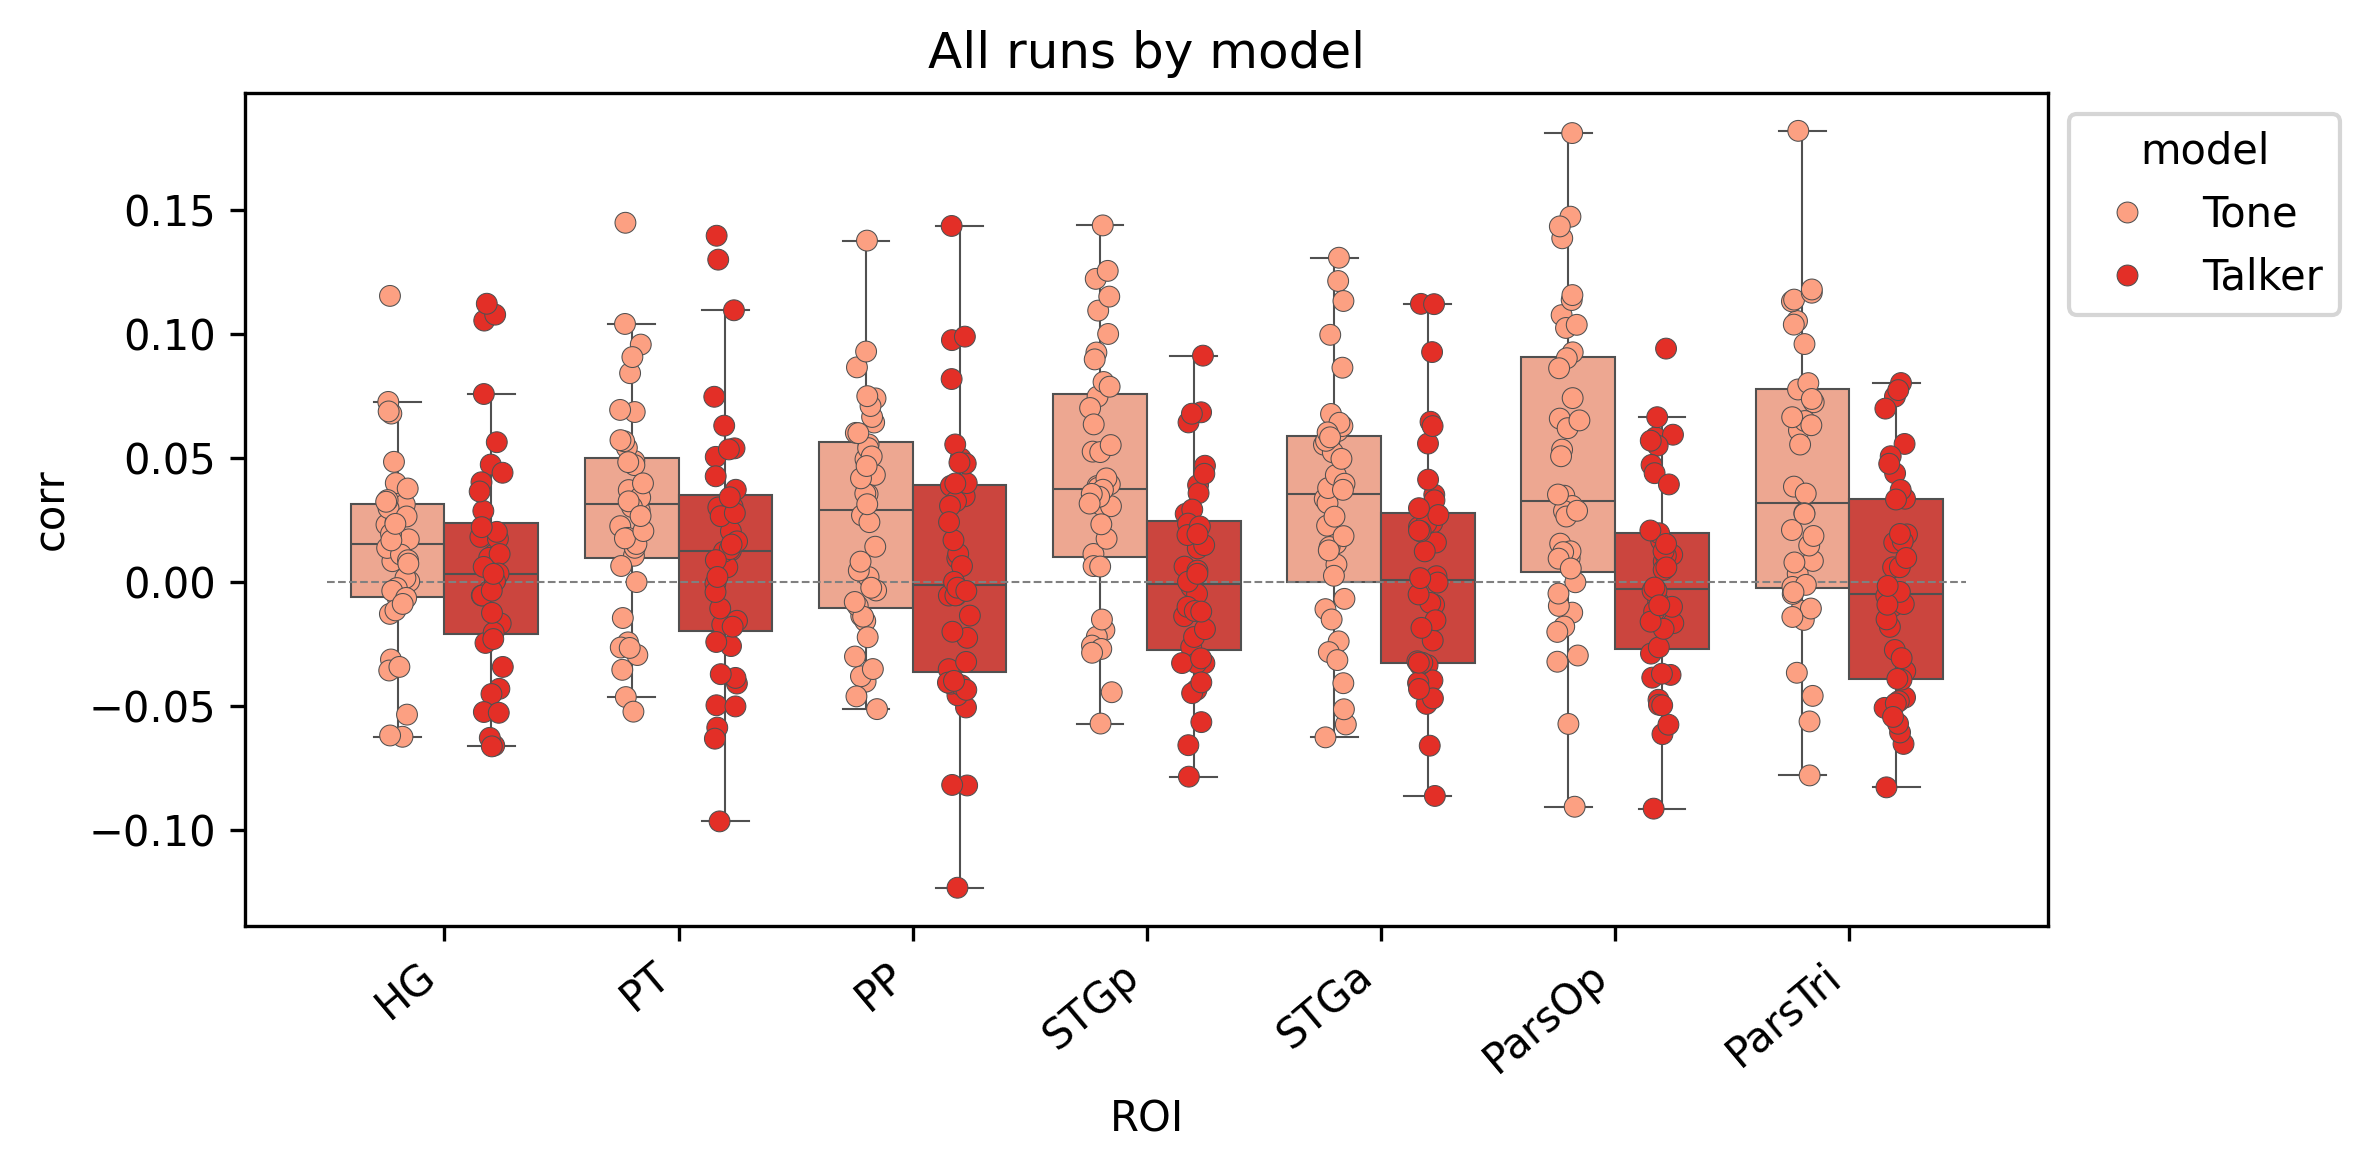

In [54]:
# combine hemispheres

fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=300, sharey=True) # sharex=True, 
#ax = ax.flatten()

group_id = 'non-Mandarin'

#for mx, group_id in enumerate(np.unique(model_long_df.participant_group)):
group_df = laterality_df.where(laterality_df.participant_group==group_id).dropna()

sns.boxplot(data=group_df, 
            x='ROI', y='corr', hue='model', 
            palette='Reds', 
            linewidth=0.5, 
            fliersize = 0,
            legend=None,
            ax=ax, 
            #order=roi_list_ordered
           )
sns.stripplot(data=group_df, 
              x='ROI', y='corr', hue='model', 
              palette='Reds', dodge=True, 
              linewidth=0.25, 
              size=5,
              ax=ax, 
              #order=roi_list_ordered,
             )
handles, labels = ax.get_legend_handles_labels()  # Get legend handles and labels

xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right');
ax.set_title(f'All runs by model');
'''
ax.legend([],[], frameon=False)

# Add legend with only strip plot handles and labels 
# (since the two overlapping plots have redundant legends)
ax.legend(handles[3:], labels[3:], 
              title='Model',
              loc='upper left', bbox_to_anchor=(1, 1))
'''
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


In [55]:
'''
fig, ax = plt.subplots(2,1, figsize=(6,6), dpi=300, sharey=True) # sharex=True, 
#ax = ax.flatten()

for mx, group_id in enumerate(np.unique(model_long_df.participant_group)):
    group_df = model_long_df.where(model_long_df.participant_group==group_id)

    sns.boxplot(data=group_df, 
                x='ROI', y='corr', hue='model', 
                palette='Reds', linewidth=0.5, 
                fliersize = 0,
                ax=ax[mx], 
                order=roi_list_ordered)
    sns.stripplot(data=group_df, 
                  x='ROI', y='corr', hue='model', 
                  palette='Reds', dodge=True, 
                  linewidth=0.25, 
                  size=1,
                  ax=ax[mx], 
                  order=roi_list_ordered)
    handles, labels = ax[mx].get_legend_handles_labels()  # Get legend handles and labels
    
    xmin, xmax = ax[mx].get_xlim()
    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
    ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=40, ha='right');
    ax[mx].set_title(f'{group_id} by model – all runs');

    #sns.move_legend(ax[mx], "upper left", bbox_to_anchor=(1, 1))
    #plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()
'''

'\nfig, ax = plt.subplots(2,1, figsize=(6,6), dpi=300, sharey=True) # sharex=True, \n#ax = ax.flatten()\n\nfor mx, group_id in enumerate(np.unique(model_long_df.participant_group)):\n    group_df = model_long_df.where(model_long_df.participant_group==group_id)\n\n    sns.boxplot(data=group_df, \n                x=\'ROI\', y=\'corr\', hue=\'model\', \n                palette=\'Reds\', linewidth=0.5, \n                fliersize = 0,\n                ax=ax[mx], \n                order=roi_list_ordered)\n    sns.stripplot(data=group_df, \n                  x=\'ROI\', y=\'corr\', hue=\'model\', \n                  palette=\'Reds\', dodge=True, \n                  linewidth=0.25, \n                  size=1,\n                  ax=ax[mx], \n                  order=roi_list_ordered)\n    handles, labels = ax[mx].get_legend_handles_labels()  # Get legend handles and labels\n    \n    xmin, xmax = ax[mx].get_xlim()\n    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color=\'0.5\', linestyle=\'--\', lin

#### By model, all runs

/scratch/slurm-3440091/ipykernel_50316/4212526346.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
/scratch/slurm-3440091/ipykernel_50316/4212526346.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');


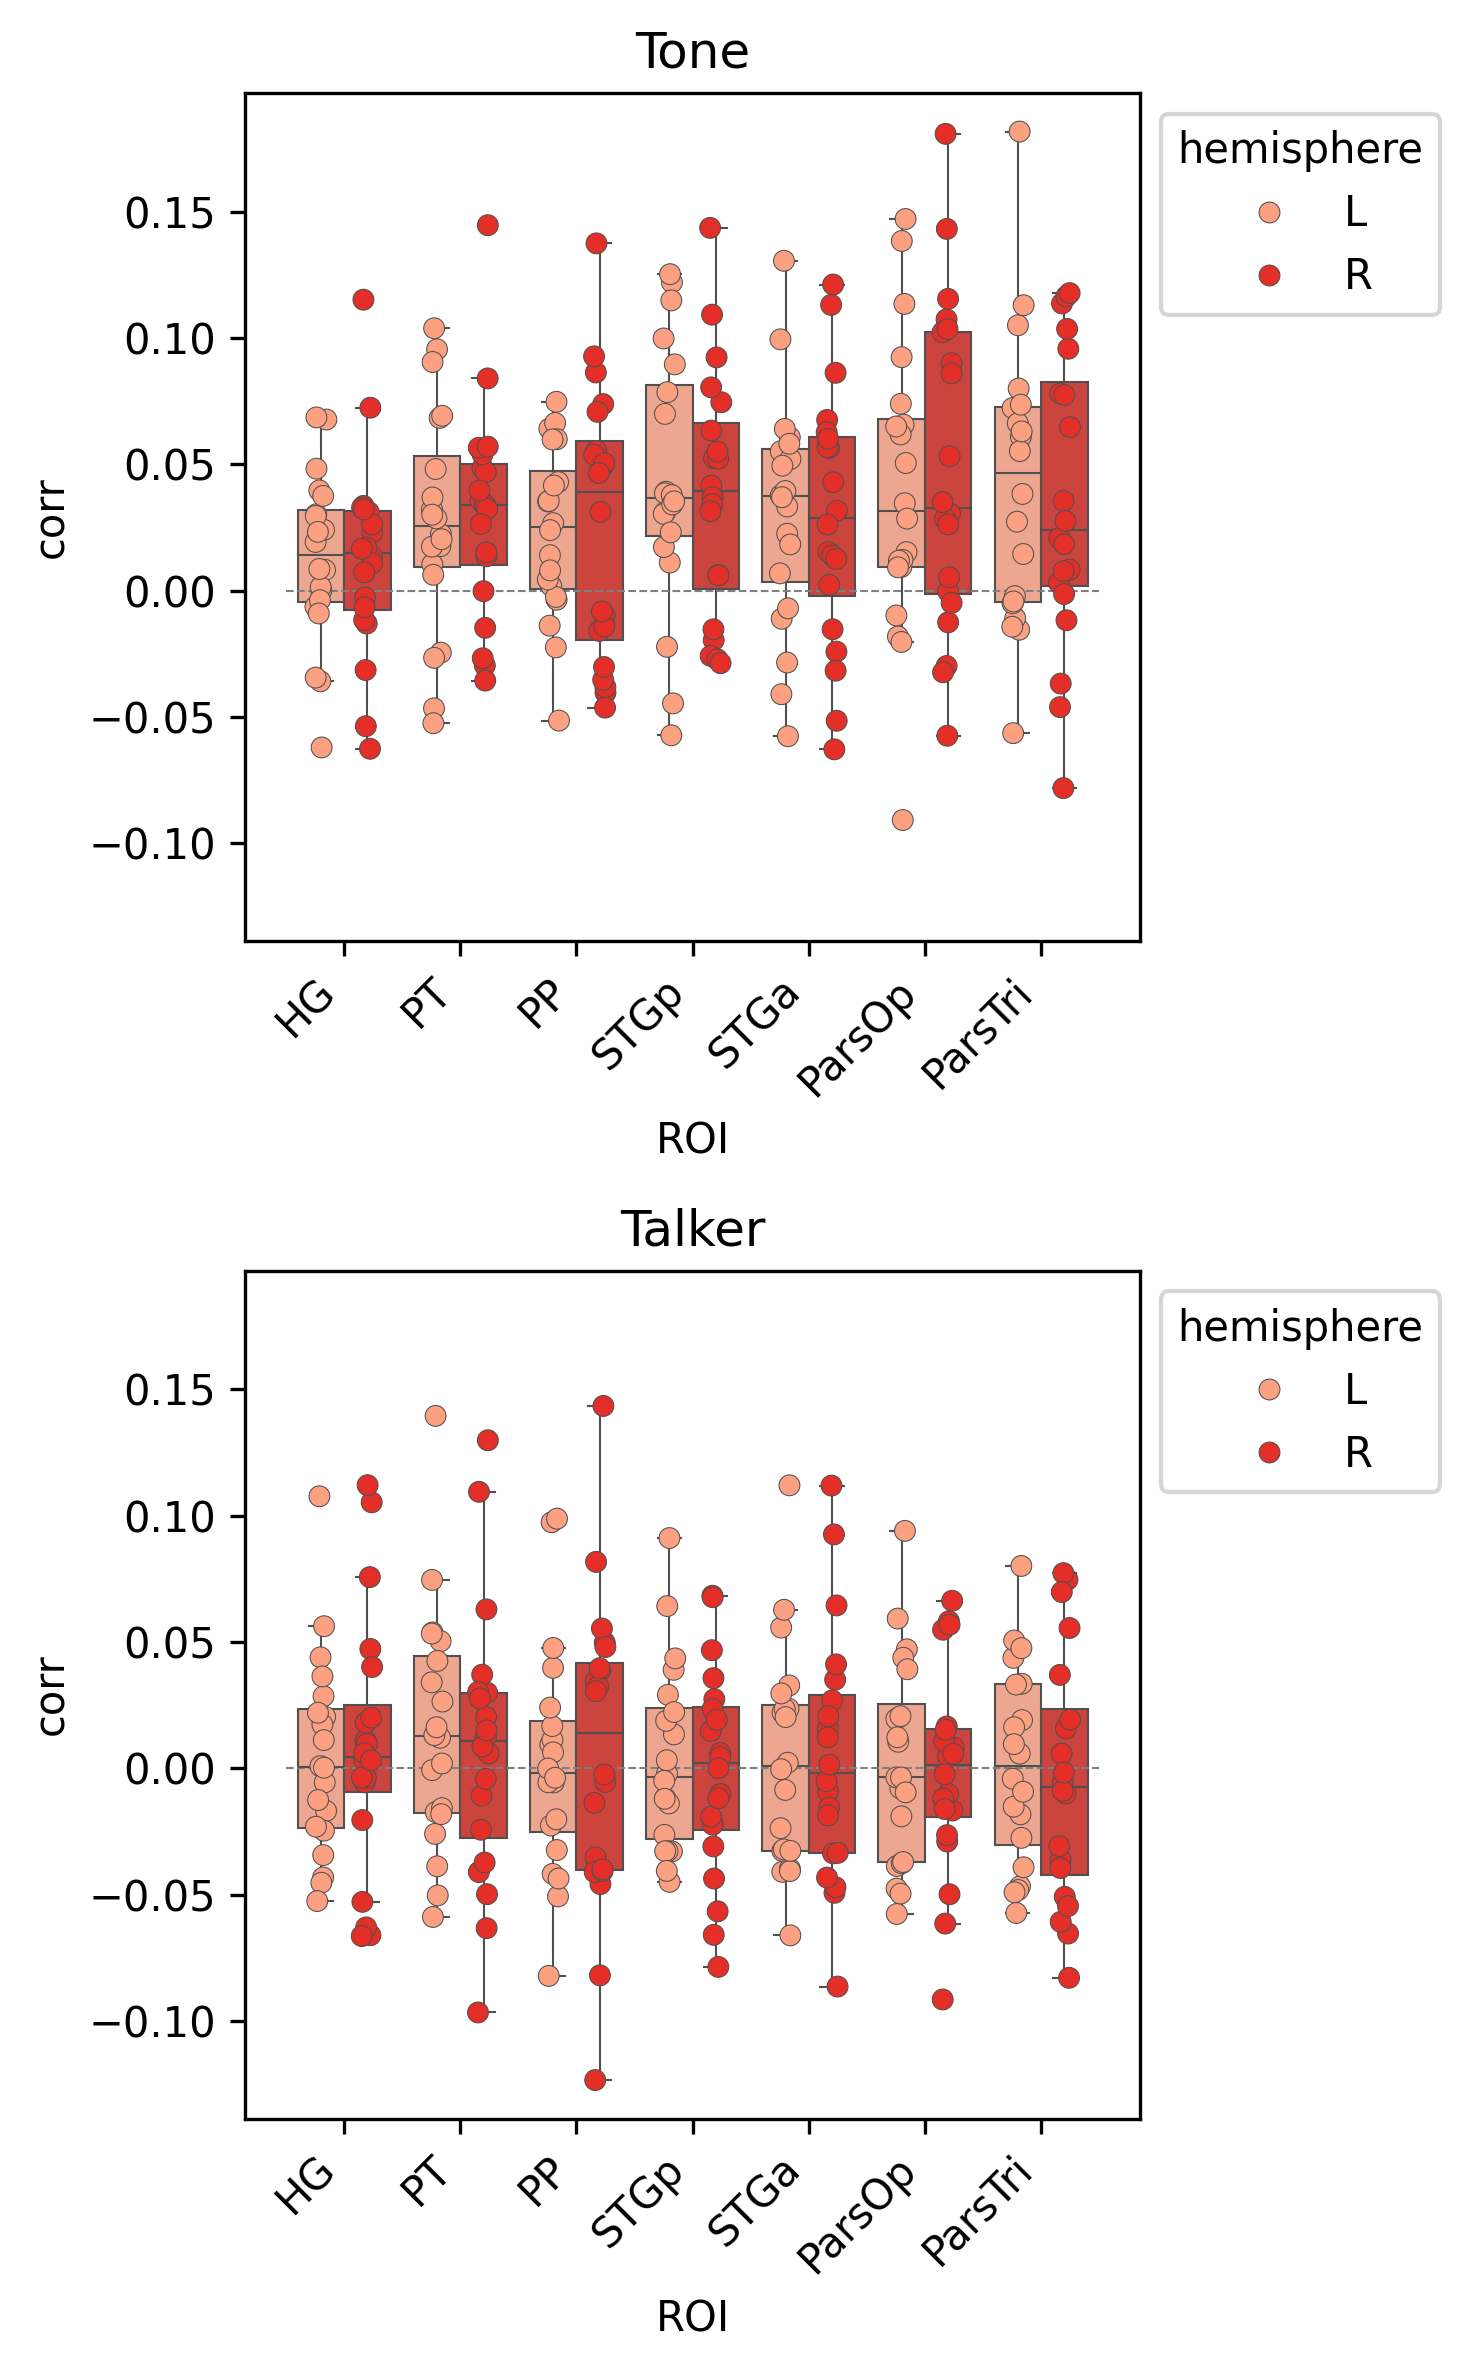

In [56]:
fig, ax = plt.subplots(2,1, figsize=(5,8), dpi=300, sharex=False, sharey=True)
#ax = ax.flatten()


for mx, model_id in enumerate(model_names):
    group_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.model==model_id)

    sns.boxplot(data=group_df, 
                x='ROI', y='corr', hue='hemisphere', 
                palette='Reds', linewidth=0.5, 
                ax=ax[mx], 
                fliersize = 0,
                legend=None,
                #boxprops=dict(alpha=.3),
                #order=roi_list_ordered
                )
    sns.stripplot(data=group_df, 
                  x='ROI', y='corr', hue='hemisphere', 
                  palette='Reds', dodge=True, 
                  linewidth=0.25, 
                  size=5,
                  ax=ax[mx], 
                  #order=roi_list_ordered,
                 )
    xmin, xmax = ax[mx].get_xlim()
    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
    sns.move_legend(ax[mx], "upper left", bbox_to_anchor=(1, 1))
    ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
    ax[mx].set_title(f'{model_id}');
    #ax[mx].legend([],[], frameon=False)
    #plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


/scratch/slurm-3440091/ipykernel_50316/913278971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
/scratch/slurm-3440091/ipykernel_50316/913278971.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');


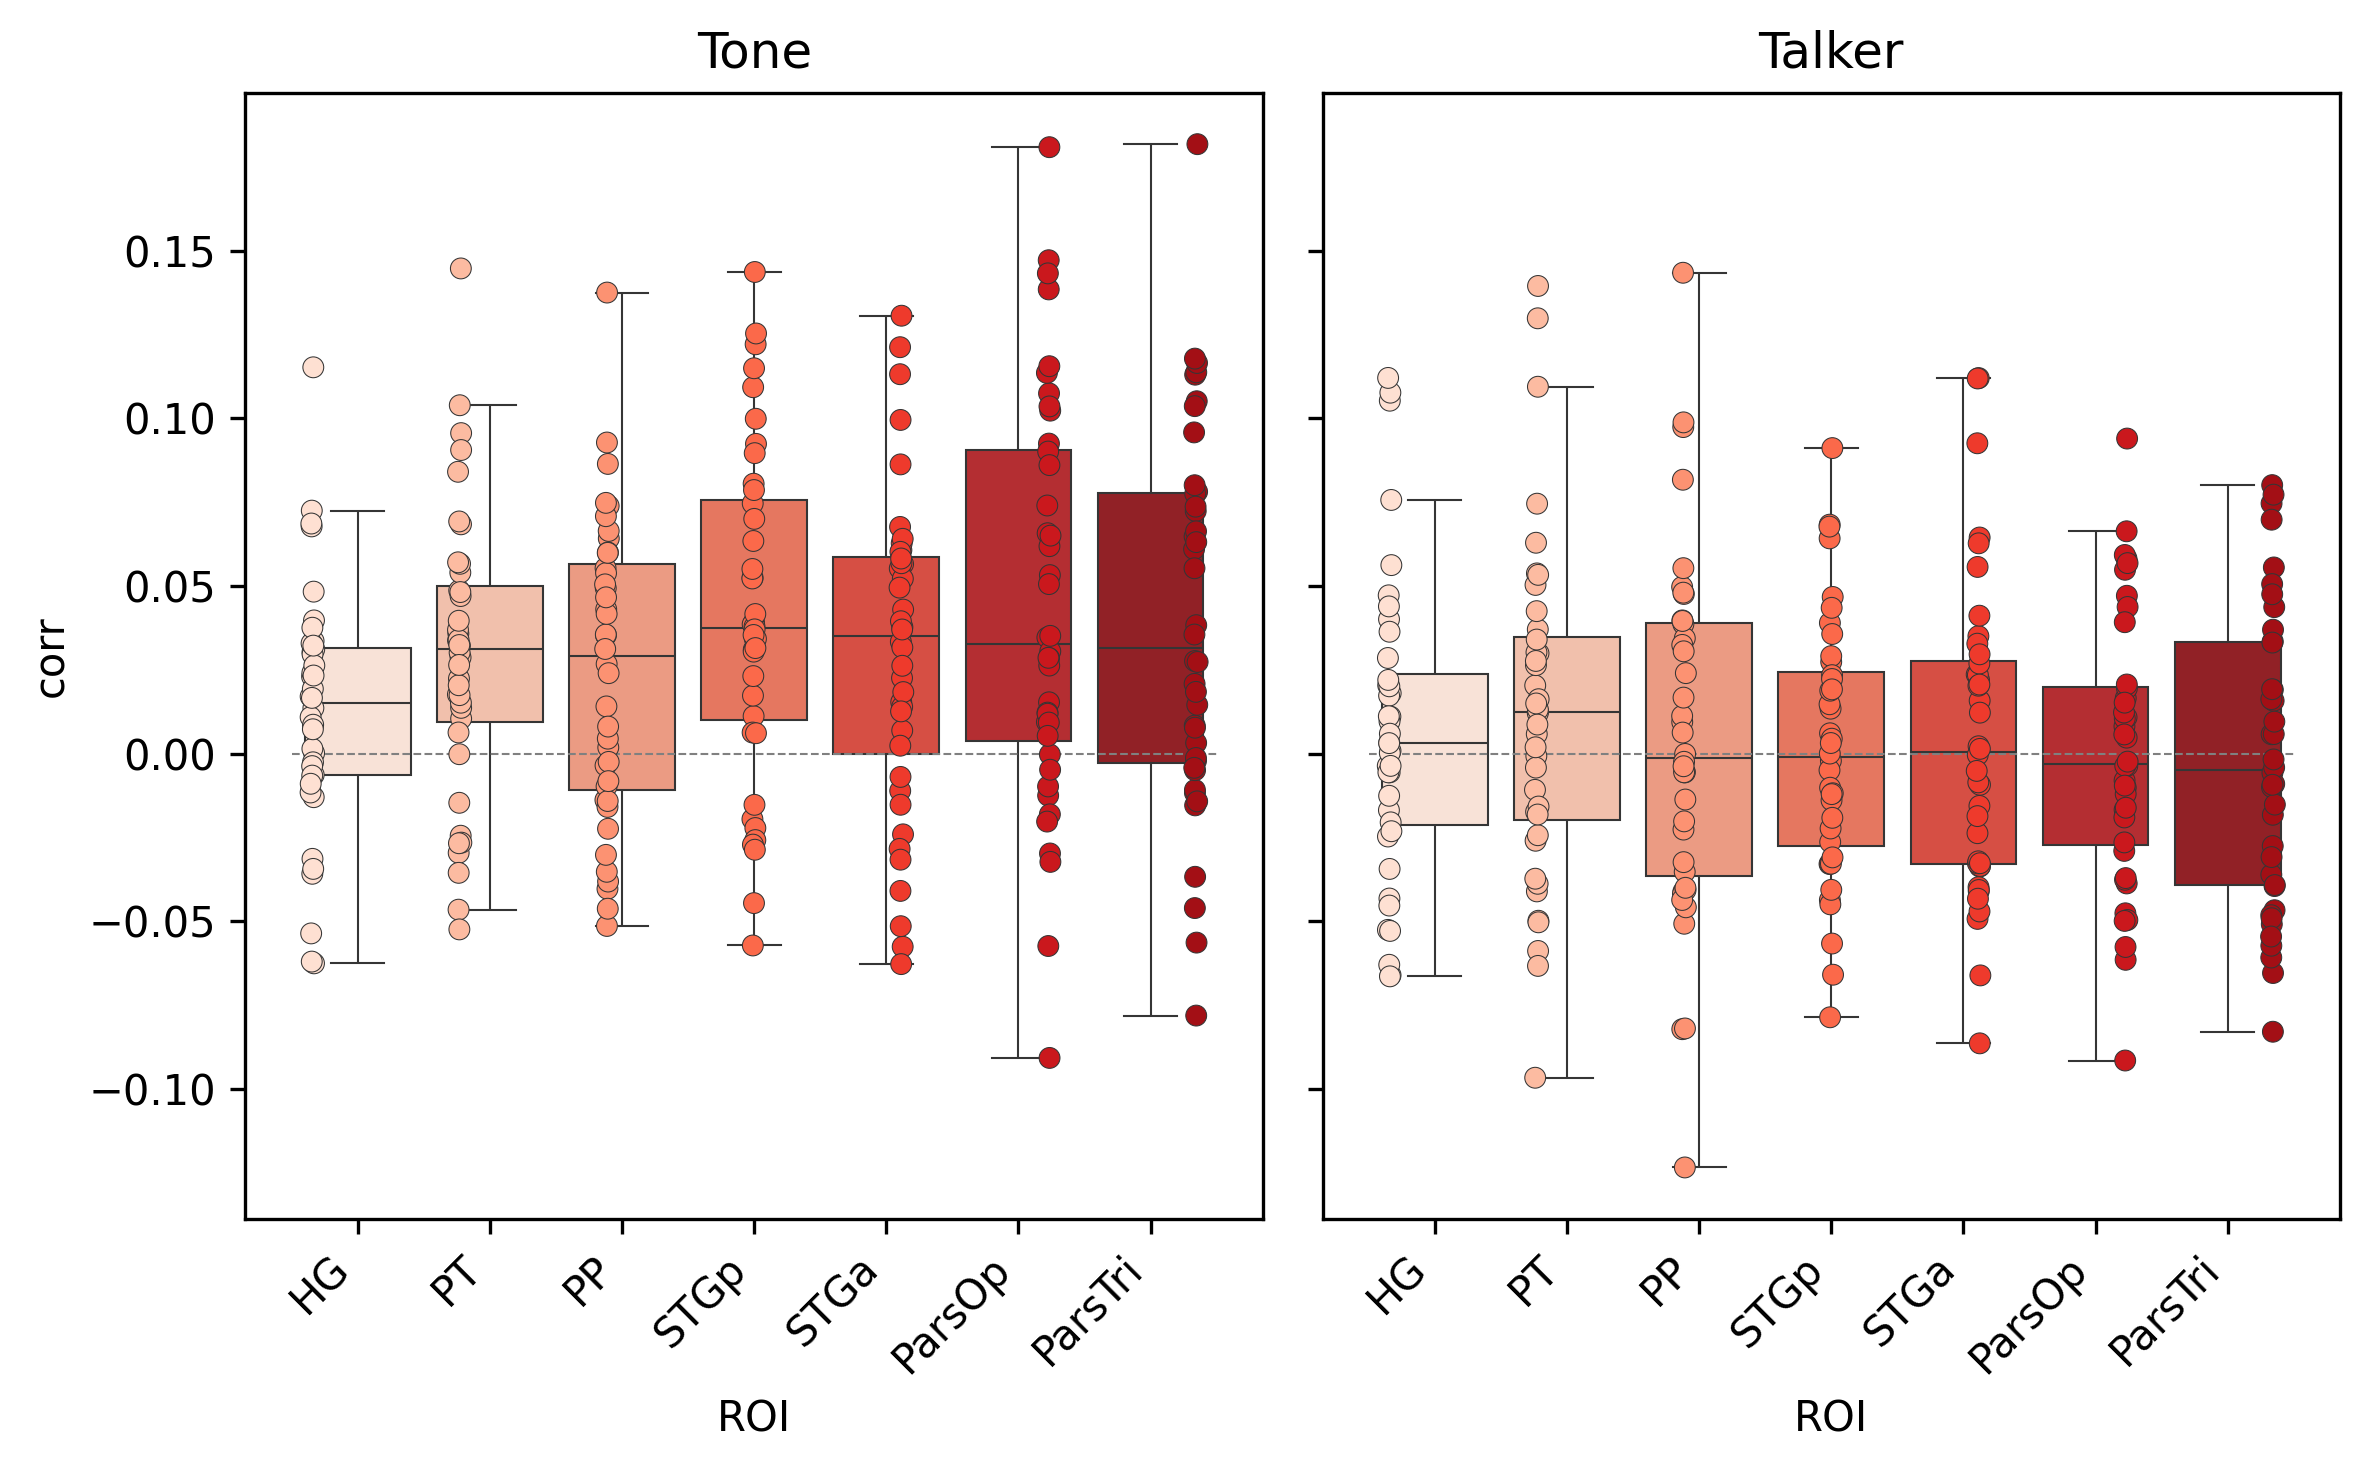

In [57]:
fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=300, sharex=False, sharey=True)
#ax = ax.flatten()


for mx, model_id in enumerate(model_names):
    group_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.model==model_id)

    sns.boxplot(data=group_df, 
                x='ROI', y='corr', hue='ROI', 
                palette='Reds', linewidth=0.5, 
                ax=ax[mx], 
                fliersize = 0,
                legend=None,
                #boxprops=dict(alpha=.3),
                #order=roi_list_ordered
                )
    sns.stripplot(data=group_df, 
                  x='ROI', y='corr', hue='ROI', 
                  legend=None,
                  palette='Reds', dodge=True, 
                  linewidth=0.25, 
                  size=5,
                  ax=ax[mx], 
                  #order=roi_list_ordered,
                 )
    xmin, xmax = ax[mx].get_xlim()
    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
    #sns.move_legend(ax[mx], "upper left", bbox_to_anchor=(1, 1))
    ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
    ax[mx].set_title(f'{model_id}');
    #ax[mx].legend([],[], frameon=False)
    #plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


/scratch/slurm-3440091/ipykernel_50316/4192290873.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');


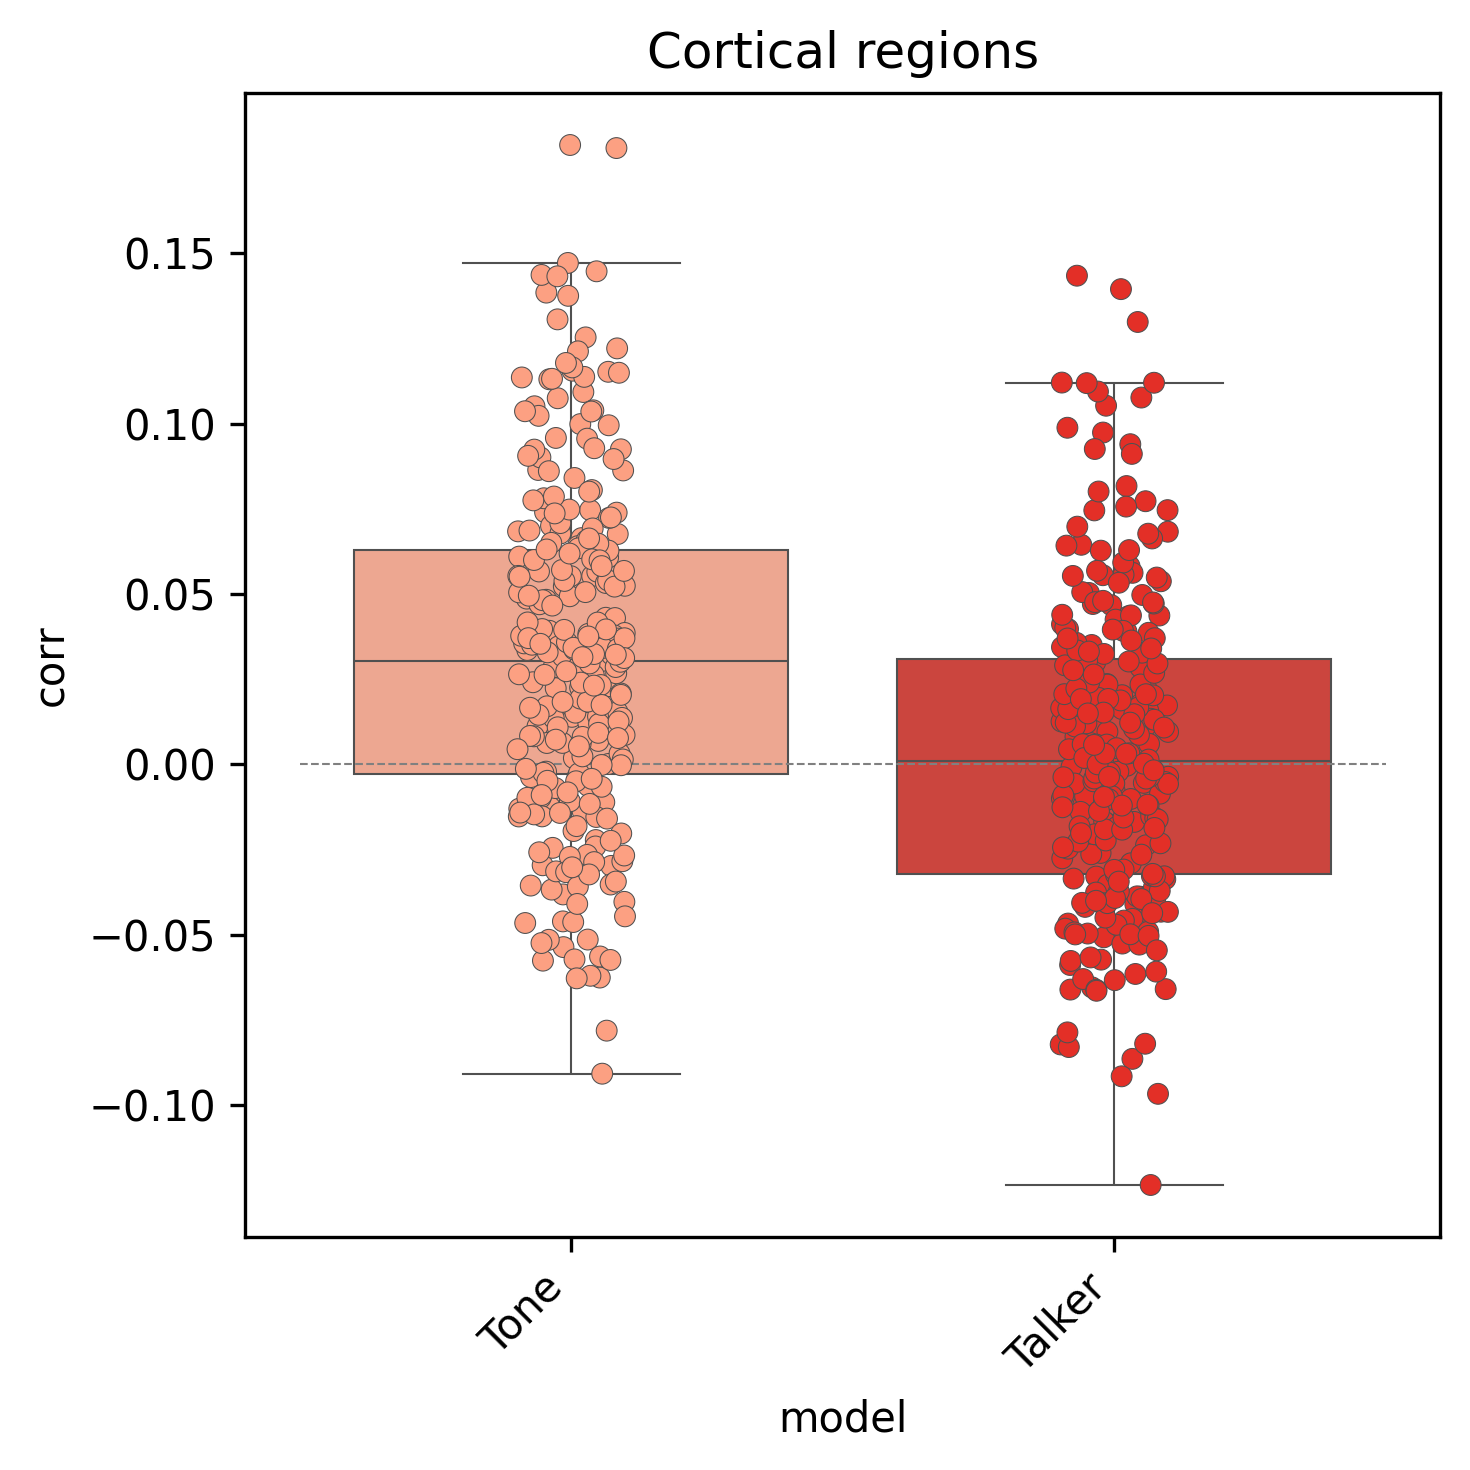

In [59]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300, sharex=False, sharey=True)

group_df = laterality_df.where(laterality_df.participant_group==group_id)

sns.boxplot(data=group_df, 
            x='model', y='corr', hue='model', 
            palette='Reds', linewidth=0.5, 
            ax=ax, 
            fliersize = 0,
            legend=None,
            #boxprops=dict(alpha=.3),
            #order=roi_list_ordered
            )
sns.stripplot(data=group_df, 
              x='model', y='corr', hue='model', 
              palette='Reds', 
              #dodge=True, 
              linewidth=0.25, 
              legend=None,
              size=5,
              ax=ax, 
              #order=roi_list_ordered,
             )
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title(f'Cortical regions');
#ax[mx].legend([],[], frameon=False)
#plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


In [ ]:
'''
fig, ax = plt.subplots(3,1, figsize=(6,8), dpi=300, sharey=True) # sharex=True, 
#ax = ax.flatten()

#for model_id in model_names:
for mx, model_id in enumerate(model_names):
    model_df = model_long_df.where(model_long_df.model==model_id)

    sns.boxplot(data=model_df, 
                x='ROI', y='corr', hue='participant_group', 
                palette='Reds', linewidth=0.5, 
                fliersize = 0,
                ax=ax[mx], 
                order=roi_list_ordered)
    sns.stripplot(data=model_df, 
                  x='ROI', y='corr', hue='participant_group', 
                  palette='Reds', dodge=True, 
                  linewidth=0.25, 
                  size=1,
                  ax=ax[mx], 
                  order=roi_list_ordered)
    handles, labels = ax[mx].get_legend_handles_labels()  # Get legend handles and labels
    
    xmin, xmax = ax[mx].get_xlim()
    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
    ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=40, ha='right');
    ax[mx].set_title(f'{model_id} by group – all runs');
    ax[mx].legend([],[], frameon=False)
    
    # Add legend with only strip plot handles and labels 
    # (since the two overlapping plots have redundant legends)
    ax[mx].legend(handles[2:], labels[2:], 
                  title='Participant group',
                  loc='upper left', bbox_to_anchor=(1, 1))
    
    #sns.move_legend(ax[mx], "upper left", bbox_to_anchor=(1, 1))
    #plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()
'''

In [ ]:
'''
fig, ax = plt.subplots(3,2, figsize=(8,10), dpi=300, sharex=True, sharey=True)
#ax = ax.flatten()

#for model_id in model_names:
for gx, group_id in enumerate(np.unique(group_rdms.rdm_descriptors['group'])):
    for mx, model_id in enumerate(model_names):
        group_df = model_long_df.where(model_long_df.participant_group==group_id).where(model_long_df.model==model_id)

        sns.boxplot(data=group_df, 
                    x='ROI', y='corr', hue='stage', 
                    palette='Reds', linewidth=0.5, 
                    ax=ax[mx,gx], 
                    order=roi_list_ordered)
        sns.stripplot(data=group_df, 
                      x='ROI', y='corr', hue='stage', 
                      palette='Reds', dodge=True, 
                      linewidth=0.25, 
                      size=1,
                      ax=ax[mx,gx], 
                      order=roi_list_ordered)
        xmin, xmax = ax[mx,gx].get_xlim()
        ax[mx,gx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
        sns.move_legend(ax[mx,gx], "upper left", bbox_to_anchor=(1, 1))
        ax[mx,gx].set_xticklabels(ax[mx,gx].get_xticklabels(), rotation=45, ha='right');
        ax[mx,gx].set_title(f'{group_id} speakers\n{model_id}');
        ax[mx,gx].legend([],[], frameon=False)
        #plt.setp(ax[mx].get_xticklabels(), visible=False)
    fig.tight_layout()
'''

#### By group, by run

/scratch/slurm-4614381/ipykernel_171167/3642082356.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');


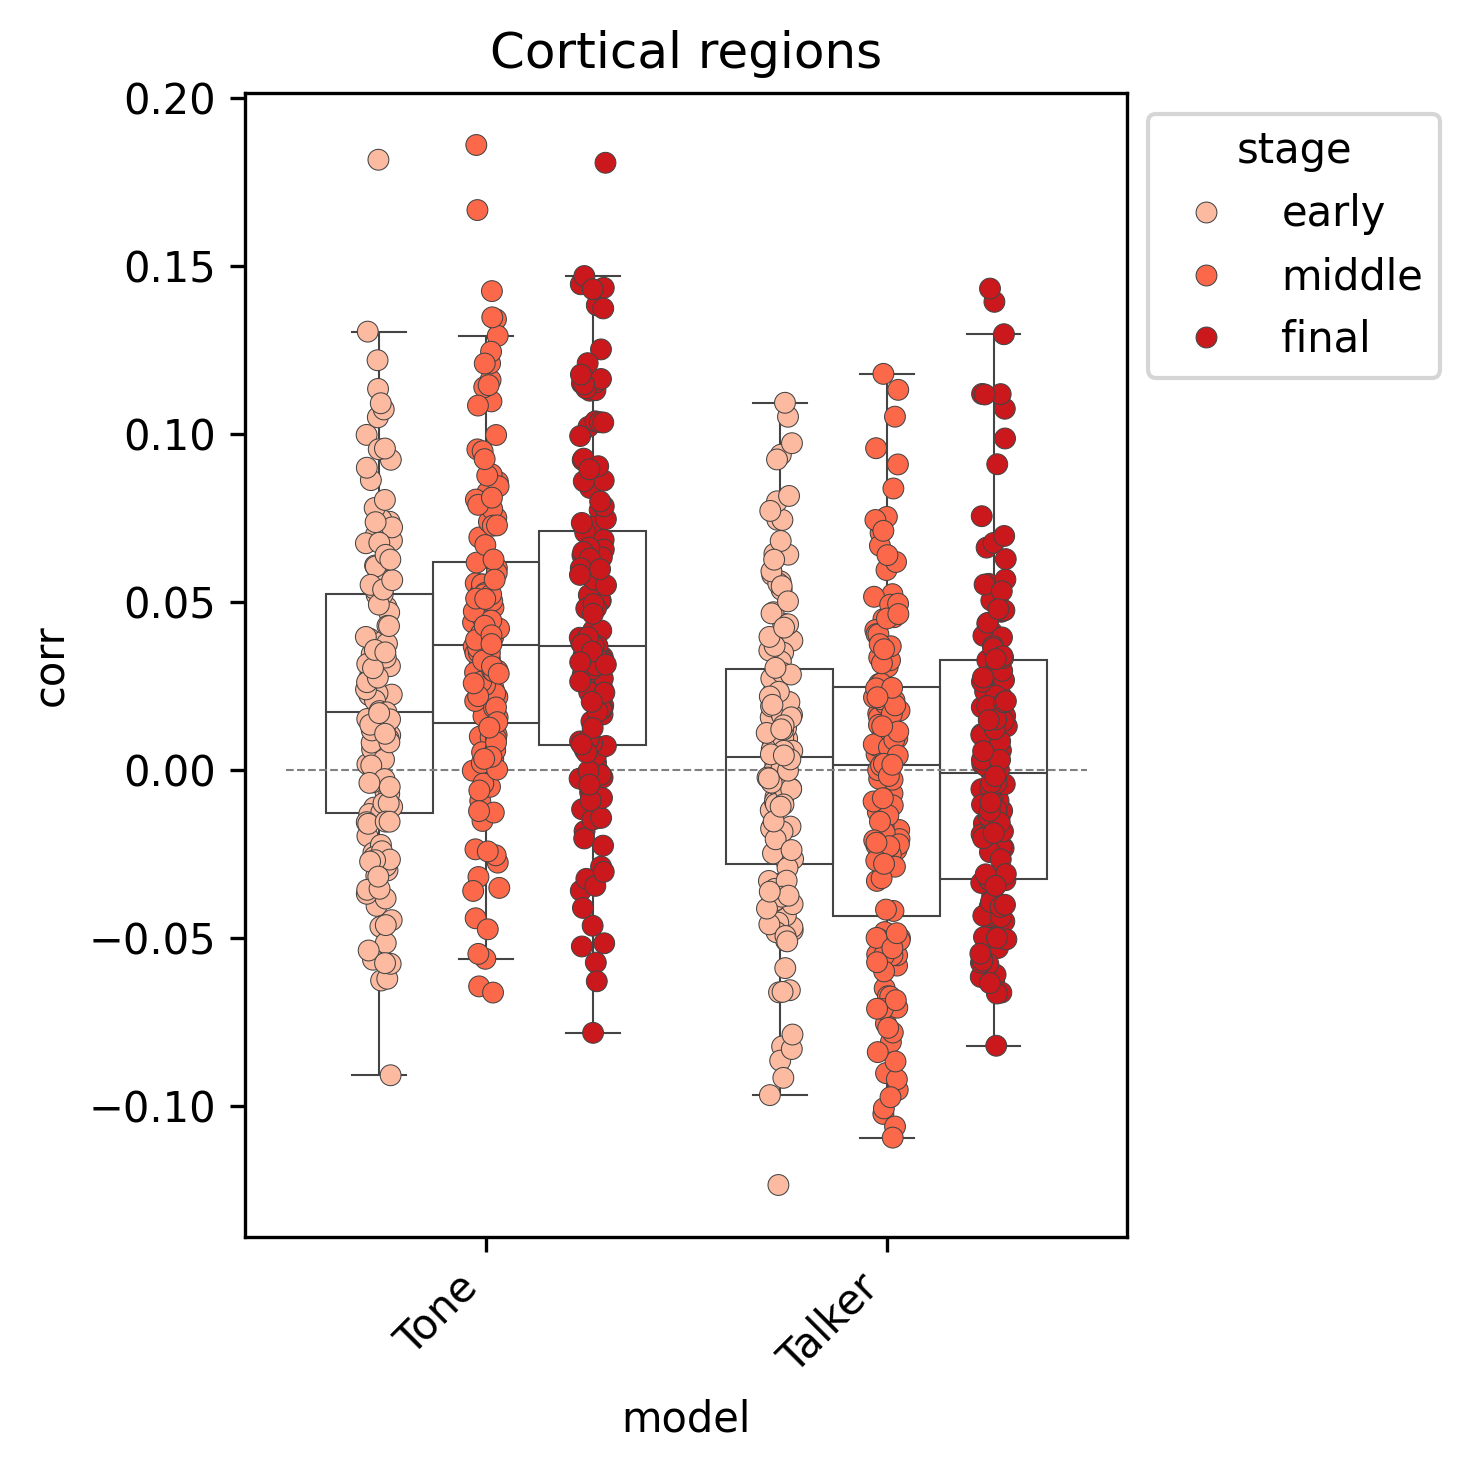

In [82]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300, sharex=False, sharey=True)

group_df = laterality_df.where(laterality_df.participant_group==group_id)

sns.boxplot(data=group_df, 
            x='model', y='corr', hue='stage', 
            palette='Reds', linewidth=0.5, 
            ax=ax, 
            fliersize = 0,
            legend=None, 
            #boxprops=dict(alpha=.3),
            #order=roi_list_ordered
            )
sns.stripplot(data=group_df, 
              x='model', y='corr', hue='stage', 
              palette='Reds', dodge=True, 
              linewidth=0.25, 
              size=5,
              ax=ax, 
              #order=roi_list_ordered,
             )
xmin, xmax = ax.get_xlim()
ax.hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title(f'Cortical regions');

# Modify the boxplot to make the boxes white (or transparent)
for patch in ax.patches:
    patch.set_facecolor('none')  # or 'none' for transparent boxes

#ax.legend([],[], frameon=False)
#plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


/scratch/slurm-3283761/ipykernel_13953/2248329281.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
/scratch/slurm-3283761/ipykernel_13953/2248329281.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');


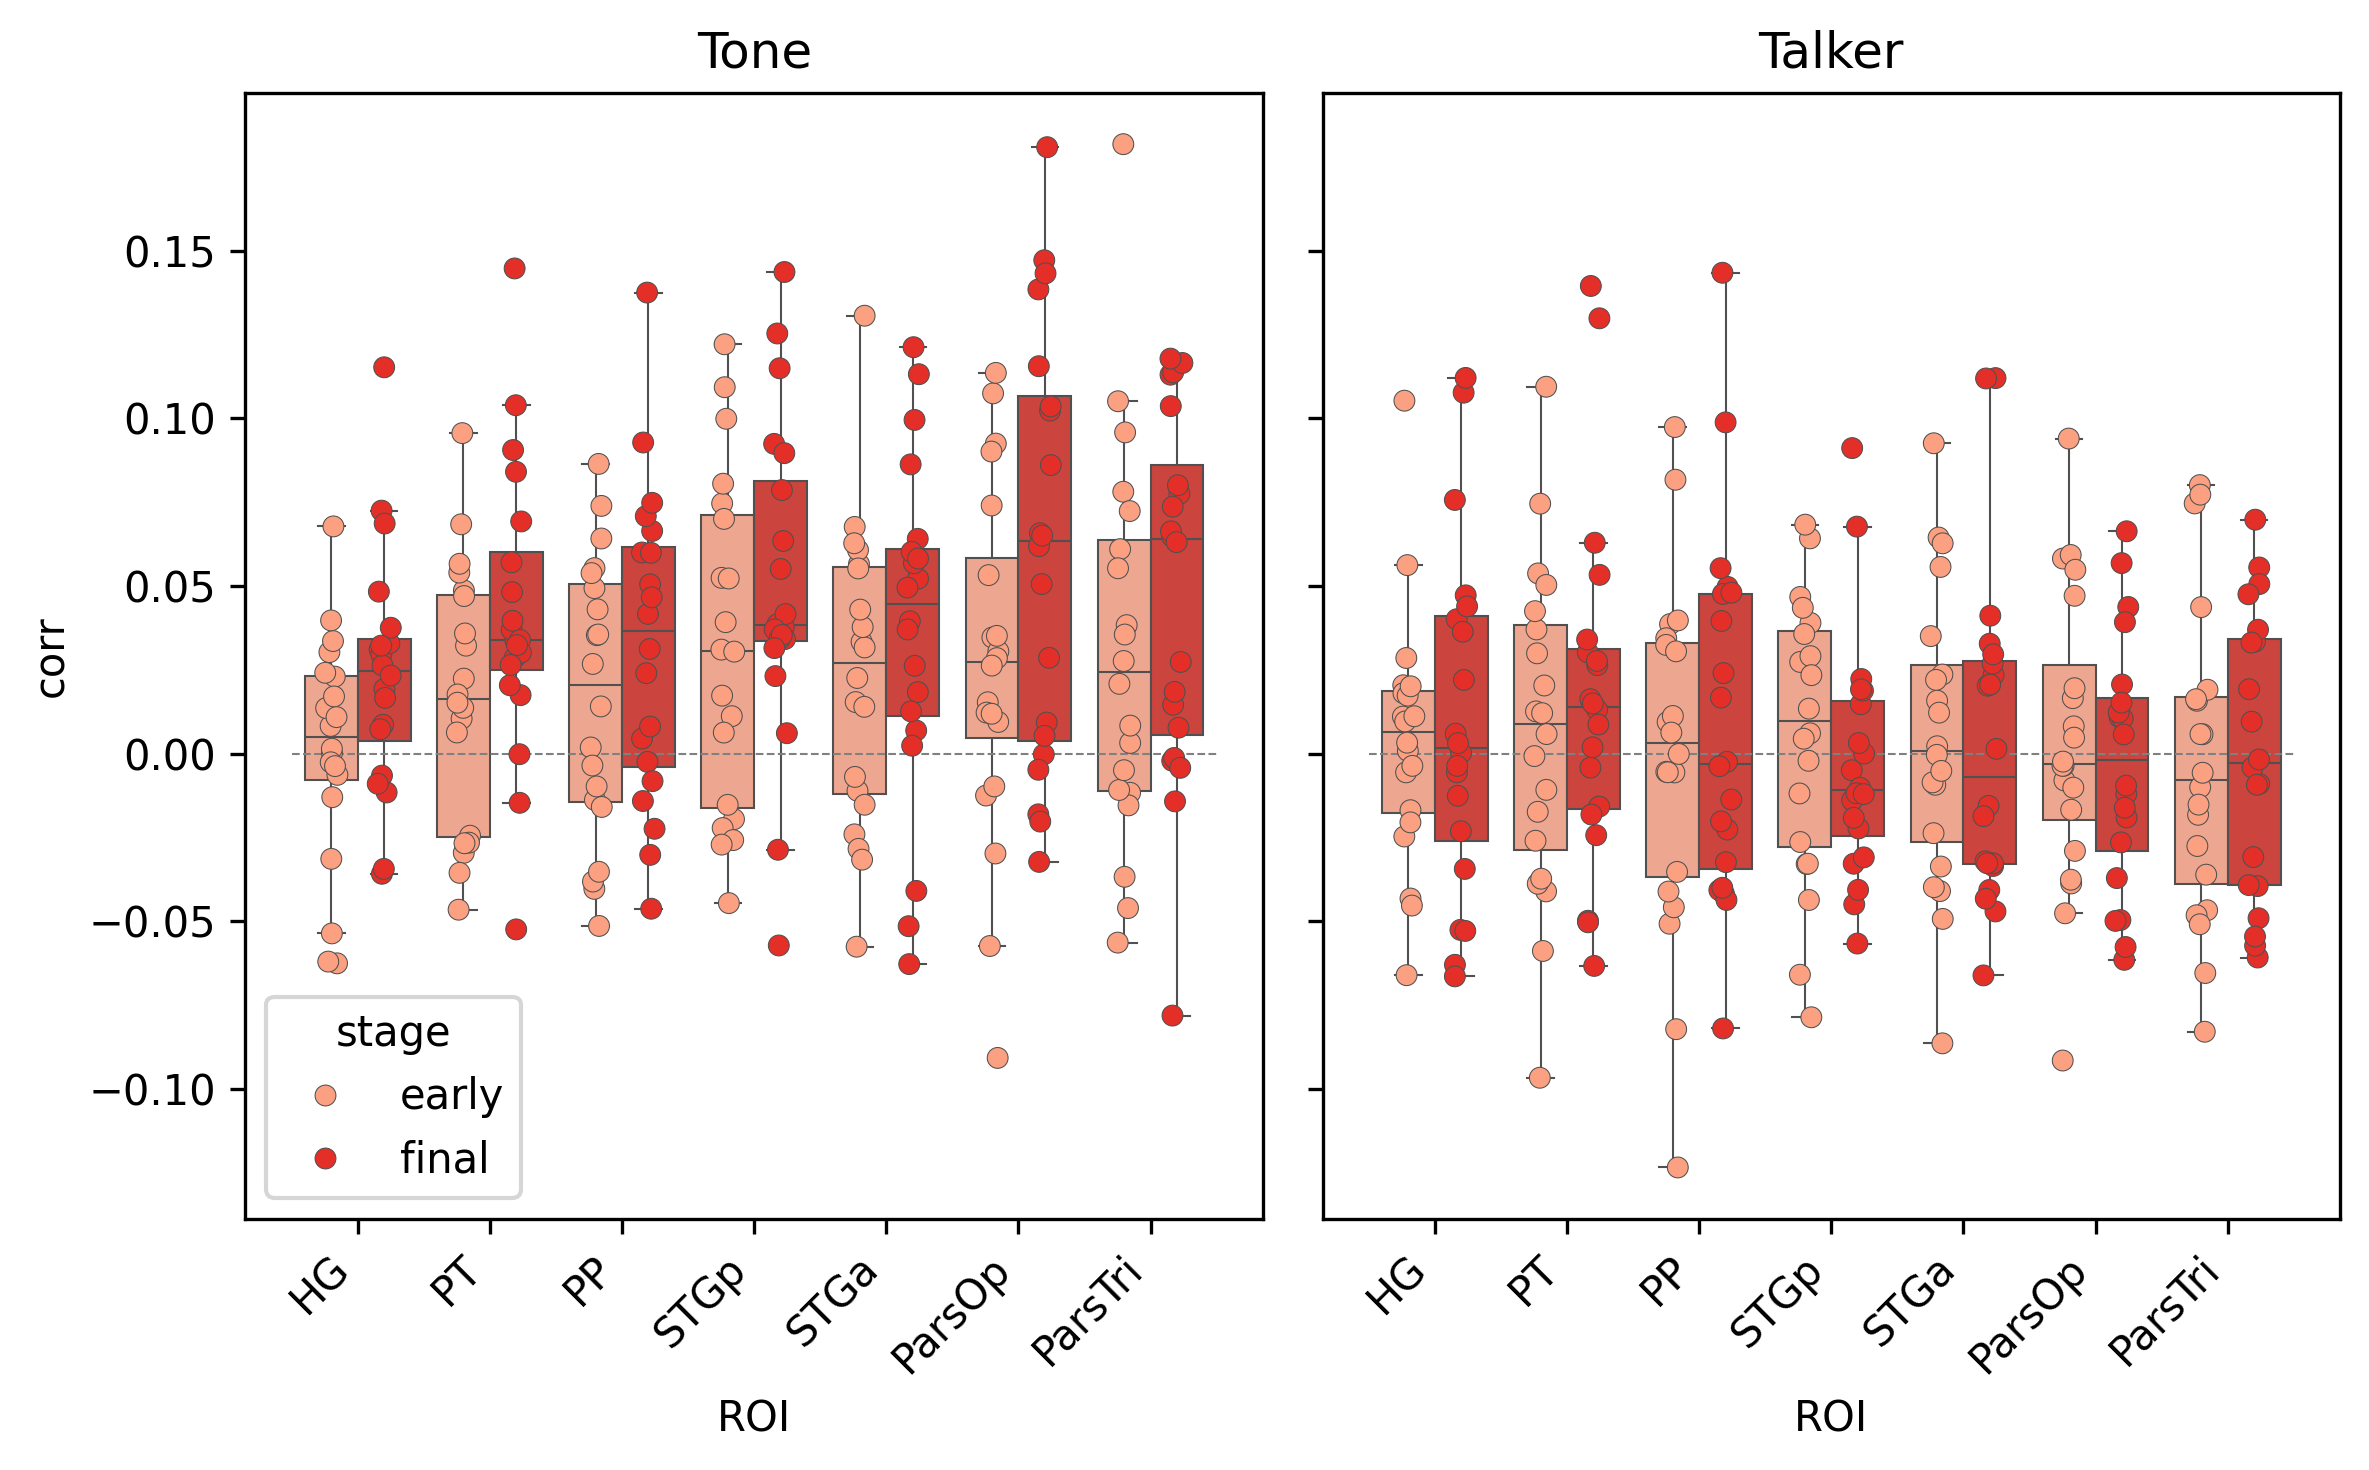

In [100]:
fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=300, sharex=False, sharey=True)
#ax = ax.flatten()


for mx, model_id in enumerate(model_names):
    group_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.model==model_id)

    sns.boxplot(data=group_df, 
                x='ROI', y='corr', hue='stage', 
                palette='Reds', 
                linewidth=0.5, 
                ax=ax[mx], 
                fliersize = 0,
                legend=None,
                #boxprops=dict(alpha=.3),
                #order=roi_list_ordered
                )
    sns.stripplot(data=group_df, 
                  x='ROI', y='corr', hue='stage', 
                  palette='Reds', dodge=True, 
                  linewidth=0.25, 
                  size=5,
                  ax=ax[mx], 
                  #order=roi_list_ordered,
                 )
    xmin, xmax = ax[mx].get_xlim()
    ax[mx].hlines(y=0, xmin=xmin, xmax=xmax, color='0.5', linestyle='--', linewidth=0.5)
    #sns.move_legend(ax[mx], "upper left", bbox_to_anchor=(1, 1))
    ax[mx].set_xticklabels(ax[mx].get_xticklabels(), rotation=45, ha='right');
    ax[mx].set_title(f'{model_id}');
    if mx > 0:
        ax[mx].legend([],[], frameon=False)
    #plt.setp(ax[mx].get_xticklabels(), visible=False)
fig.tight_layout()


### ANOVA statistics

In [65]:
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [74]:
laterality_df

,index,ROI,stage,participant_group,model,corr,hemisphere
0,0,HG,early,Mandarin,Tone,0.144426,L
1,1,PT,early,Mandarin,Tone,0.109846,L
2,2,PP,early,Mandarin,Tone,0.162085,L
3,3,STGp,early,Mandarin,Tone,0.079980,L
4,4,STGa,early,Mandarin,Tone,0.156978,L
...,...,...,...,...,...,...,...
1759,135,PP,final,non-Mandarin,Talker,-0.040013,R
1760,136,STGp,final,non-Mandarin,Talker,-0.056632,R
1761,137,STGa,final,non-Mandarin,Talker,-0.018636,R
1762,138,ParsOp,final,non-Mandarin,Talker,-0.049883,R


In [80]:
formula = 'corr ~ model'
model = ols(formula, data=laterality_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
model,0.202187,1.0,89.015764,2.025198e-20
Residual,2.666581,1174.0,NaN,NaN


In [83]:
formula = 'corr ~ hemisphere'
model = ols(formula, data=laterality_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
hemisphere,0.000721,1.0,0.295178,0.587024
Residual,2.868047,1174.0,NaN,NaN


In [82]:
formula = 'corr ~ stage'
group_id = 'non-Mandarin'
for model_id in model_names:
    print(f'\n{model_id}')

    nman_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.model==model_id) # .where(model_long_df.ROI.isin(roi_list_ordered))

    model = ols(formula, data=nman_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)



Tone
            sum_sq     df         F    PR(>F)
stage     0.030956    1.0  13.32448  0.000313
Residual  0.645865  278.0       NaN       NaN

Talker
            sum_sq     df         F    PR(>F)
stage     0.000216    1.0  0.105153  0.745975
Residual  0.571026  278.0       NaN       NaN


In [75]:
roi_names = np.unique(laterality_df.ROI)

In [79]:
formula = 'corr ~ model | ROI'
group_id = 'non-Mandarin'
for region in roi_names:
    print(f'\n{region}')

    nman_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.ROI==region) # .where(model_long_df.ROI.isin(roi_list_ordered))

    model = ols(formula, data=nman_df).fit()
    aov_table = sm.stats.anova_lm(model) #, typ=2)
    print(aov_table)



HG


PatsyError: Error evaluating factor: TypeError: unsupported operand type(s) for |: 'str' and 'str'
    corr ~ model | ROI
           ^^^^^^^^^^^

In [78]:
formula = 'corr ~ model'
group_id = 'non-Mandarin'
for region in roi_names:
    print(f'\n{region}')

    nman_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.ROI==region) # .where(model_long_df.ROI.isin(roi_list_ordered))

    model = ols(formula, data=nman_df).fit()
    aov_table = sm.stats.anova_lm(model) #, typ=2)
    print(aov_table)



HG
            df    sum_sq   mean_sq         F   PR(>F)
model      1.0  0.000787  0.000787  0.474783  0.49284
Residual  78.0  0.129255  0.001657       NaN      NaN

PP
            df    sum_sq   mean_sq         F    PR(>F)
model      1.0  0.008198  0.008198  3.432592  0.067704
Residual  78.0  0.186284  0.002388       NaN       NaN

PT
            df    sum_sq   mean_sq         F    PR(>F)
model      1.0  0.006319  0.006319  2.915992  0.091683
Residual  78.0  0.169038  0.002167       NaN       NaN

ParsOp
            df    sum_sq   mean_sq          F    PR(>F)
model      1.0  0.038130  0.038130  14.352797  0.000297
Residual  78.0  0.207219  0.002657        NaN       NaN

ParsTri
            df    sum_sq   mean_sq          F   PR(>F)
model      1.0  0.033106  0.033106  12.989412  0.00055
Residual  78.0  0.198800  0.002549        NaN      NaN

STGa
            df    sum_sq   mean_sq         F   PR(>F)
model      1.0  0.013996  0.013996  6.379606  0.01357
Residual  78.0  0.171119  0.0021

In [73]:
formula = 'corr ~ ROI'
group_id = 'non-Mandarin'
for model_id in model_names:
    print(f'\n{model_id}')

    nman_df = laterality_df.where(laterality_df.participant_group==group_id).where(laterality_df.model==model_id) # .where(model_long_df.ROI.isin(roi_list_ordered))

    model = ols(formula, data=nman_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(aov_table)



Tone
            sum_sq     df         F    PR(>F)
ROI       0.028622    6.0  2.009116  0.064653
Residual  0.648199  273.0       NaN       NaN

Talker
            sum_sq     df         F    PR(>F)
ROI       0.004513    6.0  0.362305  0.902319
Residual  0.566729  273.0       NaN       NaN


## Run-all

In [ ]:
model_desc = 'run-all_LSS'

### Load run-all subject-specific RDMs

In [ ]:
# from `rsa_roi.py`-generated outputs
group_rdm_list = []
for sx, sub_id in enumerate(participant_list): # enumerate(['FLT03']): #
    print(sub_id)
    group_id = group_assignment[sx]

    out_dir = os.path.join(model_dir, 'rsa_roi', network_name)
    os.makedirs(out_dir, exist_ok=True)
    sub_fpath = os.path.join(out_dir,
                         f'sub-{sub_id}_{network_name}_{model_desc}_rdms.hdf5')
    sub_rdm = rsatoolbox.rdm.rdms.load_rdm(sub_fpath)
    
    # add the group descriptor to the subject's RDM
    sub_rdm.rdm_descriptors['group'] = [group_id for x in sub_rdm.rdm_descriptors['index']]
    group_rdm_list.append(sub_rdm)
runall_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

In [ ]:
sub_rdm

### plot all RDMs

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20,30), dpi=500)
fig.suptitle('Single-participant ROI RDMs')

subfigs = fig.subfigures(nrows=len(participant_list), ncols=1)

for sx, sub_id in enumerate(participant_list):
    subfigs[sx].suptitle(f'{sub_id} - {group_assignment[sx]} group')
    axes = subfigs[sx].subplots(nrows=1, ncols=len(roi_list_ordered))
    for rx, roi in enumerate(roi_list_ordered):
        rsatoolbox.vis.show_rdm_panel(runall_rdms.subset('participant', value=sub_id).subset('ROI', value=roi), 
                                        ax=axes[rx],
                                        rdm_descriptor='ROI', 
                                        cmap='inferno',
                                        #show_colorbar='panel', # cut figsize height in half if showing colorbar
                                       );


### Mean RDMs across participants per group

In [ ]:
roi_list = roi_list_ordered

In [ ]:
mean_rdms_mand_list = []
mean_rdms_nman_list = []
for rx, roi in enumerate(roi_list):
    # Mandarin-speaking
    dissim_mand = runall_rdms.subset('group', value='Mandarin').subset('ROI', value=roi).dissimilarities
    
    roi_mand = RDMs(dissim_mand.mean(axis=0),
                    rdm_descriptors={'ROI': roi_list[rx], 'group': 'Mandarin'},
                    pattern_descriptors=pattern_descriptors)
    mean_rdms_mand_list.append(roi_mand)
    
    # non-Mandarin-speaking
    dissim_nman = runall_rdms.subset('group', value='non-Mandarin').subset('ROI', value=roi).dissimilarities
    roi_nman = RDMs(dissim_nman.mean(axis=0),
                    rdm_descriptors={'ROI': roi_list[rx], 'group': 'non-Mandarin'},
                    pattern_descriptors=pattern_descriptors)
    mean_rdms_nman_list.append(roi_nman)

mean_rdms_mand = rsatoolbox.rdm.rdms.concat(mean_rdms_mand_list)
mean_rdms_nman = rsatoolbox.rdm.rdms.concat(mean_rdms_nman_list)



In [ ]:
mean_rdms_nman

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20,4), dpi=500)
fig.suptitle('Mean RDMs by group and ROI')

subfigs = fig.subfigures(nrows=2, ncols=1)

n_mand = len(sub_group_dict['Mandarin'])
n_nman = len(sub_group_dict['non-Mandarin'])

subfigs[0].suptitle(f'Mandarin-speaking group (n = {n_mand})')
subfigs[1].suptitle(f'non-Mandarin-speaking group (n = {n_nman})')

axs0 = subfigs[0].subplots(nrows=1, ncols=len(roi_list))
axs1 = subfigs[1].subplots(nrows=1, ncols=len(roi_list))
for rx, roi in enumerate(roi_list):
    rsatoolbox.vis.show_rdm_panel(mean_rdms_mand.subset('ROI', value=roi), 
                                  rdm_descriptor='ROI', 
                                  cmap='inferno', 
                                  ax=axs0[rx])
    rsatoolbox.vis.show_rdm_panel(mean_rdms_nman.subset('ROI', value=roi), 
                                  rdm_descriptor='ROI', 
                                  cmap='inferno', 
                                  ax=axs1[rx])

#### MDS

In [ ]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_mand, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

In [ ]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

### Model comparisons

In [ ]:
[x.name for x in cat_models]

#### Across all ROIs

In [ ]:
'''
group = 'Mandarin'
ROI = 'mask-R-ParsTri'
'''
group_results = {}
for group in np.unique(runall_rdms.rdm_descriptors['group']):
    group_results[group] = {}
    print(f'group-{group}')
    results_grr = rsatoolbox.inference.eval_fixed(cat_models, 
                                                  runall_rdms.subset('group', value=group),  
                                                  method='corr',)

    fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
    ax1.set_title(f'group-{group} network-{network_name}');
    ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

    #results_grr.save(f'results-eval/run-all/results-eval_denoised_run-all_group-{group}_{network_name}_ROI-{ROI}.hdf5',overwrite=True)

    group_results[group]['Tone'] = results_grr.to_dict()['evaluations'][0][0]
    group_results[group]['Talker'] = results_grr.to_dict()['evaluations'][0][1]
    #roi_results[group][ROI] = results_grr.to_dict()['evaluations']


#### Per ROI

In [ ]:
'''
group = 'Mandarin'
ROI = 'mask-R-ParsTri'
'''
roi_results = {}
for group in np.unique(runall_rdms.rdm_descriptors['group']):
    roi_results[group] = {}
    for ROI in np.unique(runall_rdms.rdm_descriptors['ROI']):
        print(f'group-{group} ROI-{ROI}')
        results_grr = rsatoolbox.inference.eval_fixed(cat_models, 
                                                      runall_rdms.subset('group', value=group).subset('ROI',value=ROI),  
                                                      method='corr',)
        
        fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
        ax1.set_title(f'group-{group} ROI-{ROI}');
        ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")
        
        #results_grr.save(f'results-eval/run-all/results-eval_denoised_run-all_group-{group}_{network_name}_ROI-{ROI}.hdf5',overwrite=True)
        
        roi_results[group][ROI] = {}
        roi_results[group][ROI]['Tone'] = results_grr.to_dict()['evaluations'][0][0]
        roi_results[group][ROI]['Talker'] = results_grr.to_dict()['evaluations'][0][1]
        #roi_results[group][ROI] = results_grr.to_dict()['evaluations']
        

In [ ]:
results_grr.to_dict()['evaluations']

In [ ]:
print(results_grr.summary())

#### Custom plots

In [ ]:
roi_results

In [ ]:
pd.DataFrame.from_dict(roi_results['Mandarin'], orient='index')

# ARCHIVE

### [DO NOT RUN - FILES CURRENTLY MISSING/REANALYZED] Stimulus RDMs

In [ ]:
stim_rdm_dir = os.path.abspath('/bgfs/bchandrasekaran/ngg12/16tone/analysis_scripts/RDMs_kevin')

In [ ]:
glob(stim_rdm_dir+'/STIM*')

In [ ]:
stim_rdm_files = sorted(glob(stim_rdm_dir+'/STIM*PCA*'))
n_rdms = len(stim_rdm_files)
stim_rdms_name_list = []
stim_rdms_array = np.zeros((n_rdms, 16, 16))
for i, fpath in enumerate(stim_rdm_files):
    rdm_name = os.path.basename(fpath)[5:-4]
    print(rdm_name)
    stim_rdm_data = np.genfromtxt(fpath, delimiter=',', skip_header=1)
    try:
        stim_rdms_array[i] = stim_rdm_data
        stim_rdms_name_list.append(rdm_name)
    except ValueError:
        # some of the DSMs are 4x4 instead of 16x16
        # so skip them
        continue

In [ ]:
stim_rdms_array.shape

In [ ]:
stim_rdms = RDMs(stim_rdms_array,
                  rdm_descriptors={'stimulus_model':stim_rdms_name_list,},
                  pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                  )

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(8,5), dpi=200)
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_rdms = stim_rdms.subset('stimulus_model', descrip)
    show_rdm_panel(spec_rdms, ax=axs.flat[dx], rdm_descriptor='stimulus_model', cmap='inferno',)


#### Convert to models

In [ ]:
stim_models = []
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_model = ModelFixed( '{} RDM'.format(descrip), stim_rdms.subset('stimulus_model', descrip))
    stim_models.append(spec_model)

### [DO NOT RUN - FILES CURRENTLY MISSING/REANALYZED] FFR RDMs

In [ ]:
# start with grand average FFR
print('loading FFR dissimilarity matrix')
ffr_rdm_fpath = os.path.join(stim_rdm_dir, 'FFRdistancesgrandavg.csv')
rdm_name = 'FFR_grandavg'
ffr_rdm_data = np.genfromtxt(fpath, delimiter=',', skip_header=1)
print(len(ffr_rdm_data))

# input array needs to be 3-dimensional, despite docs saying 2-D is ok
# (thus the newaxis)
ffr_rdm = RDMs(ffr_rdm_data[np.newaxis,:,:],
               rdm_descriptors={'FFR model': rdm_name},
               pattern_descriptors=pattern_descriptors,
               dissimilarity_measure='Euclidean')
ffr_model = ModelFixed('FFR model', ffr_rdm)

ffr_models = [ffr_model]
    

In [ ]:
show_rdm(ffr_rdm, cmap='inferno',)

## [DO NOT RUN – ARCHIVE] Generate run-specific RDMs (NOW RUN WITH RSA_ROI.PY)

#### Generate group RDMs

In [ ]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    # set this path to wherever you saved the folder containing the img-files
    model_folder = os.path.join(model_dir, 'masked_statmaps',
                               'sub-{}'.format(sub_id),
                               'statmaps_masked',
                               'stimulus_per_run_LSS')
    for runx, data_folder in enumerate(sorted(glob('{}/run*'.format(model_folder)))):
        #print(data_folder)
        
        #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

        all_mask_data = []
        for mx, mask_descrip in enumerate(roi_list):

            #print(mask_descrip)
            image_paths = sorted(glob('{}/mask-{}/*_cond-*_map-{}.csv'.format(data_folder, mask_descrip, statmap)))

            try:
                n_vox = np.genfromtxt(image_paths[0]).shape[0]
            except IndexError:
                n_vox = 1

            data = np.zeros((len(image_paths), n_vox))
            for x, im in enumerate(image_paths):
                data[x] = np.genfromtxt(im)
            all_mask_data.append(data)

            roi_rdms = []
        for rx, mask_data in enumerate(all_mask_data):
            dataset = rsatoolbox.data.Dataset(mask_data, 
                                              descriptors={'participant': sub_id, 
                                                           'run': os.path.basename(data_folder),
                                                           'ROI': roi_list[rx], 
                                                           'group': group_id
                                                          },)
            test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
            roi_rdms.append(test_rdm)
            group_rdm_list.append(test_rdm)

        concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

In [ ]:
group_rdm_list

In [ ]:
test_rdm

In [ ]:
group_rdms.pattern_descriptors = pattern_descriptors

In [ ]:
group_rdms.save('group_run_LSS_rdms.hdf5', file_type='hdf5', overwrite=True)

#### Load pre-saved run-specific RDMs

In [ ]:
group_rdms = rsatoolbox.rdm.rdms.load_rdm('group_run_LSS_rdms.hdf5')

## [ARCHIVE] Run-specific RSA

### Create group-mean RDMs

In [ ]:
mean_rdms_mand_list = []
mean_rdms_nman_list = []
for runx, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    for rx, roi in enumerate(roi_list):
        # Mandarin-speaking
        dissim_mand = group_rdms.subset('group', value='Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities

        roi_mand = RDMs(dissim_mand.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': roi_list[rx], 'group': 'Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_mand_list.append(roi_mand)

        # non-Mandarin-speaking
        dissim_nman = group_rdms.subset('group', value='non-Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities
        roi_nman = RDMs(dissim_nman.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': roi_list[rx], 'group': 'non-Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_nman_list.append(roi_nman)

mean_rdms_mand = rsatoolbox.rdm.rdms.concat(mean_rdms_mand_list)
mean_rdms_nman = rsatoolbox.rdm.rdms.concat(mean_rdms_nman_list)



In [ ]:
mean_rdms_mand

#### plot data RDMs

In [ ]:
n_mand = len(sub_group_dict['Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Mandarin (n = {}) mean RDMs by run and ROI'.format(n_mand))

subfigs = fig.subfigures(nrows=6, ncols=1)


for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(roi_list))
    for rx, roi in enumerate(roi_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_mand.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

In [ ]:
n_nman = len(sub_group_dict['non-Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Non-Mandarin (n = {}) mean RDMs by run and ROI'.format(n_nman))

subfigs = fig.subfigures(nrows=6, ncols=1)

for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(roi_list))
    for rx, roi in enumerate(roi_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_nman.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

In [ ]:
for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman.subset('run', run), 
                                         rdm_descriptor='ROI',
                                         pattern_descriptor='tone');

### Each run independently

In [ ]:
len(group_rdms.get_matrices()[0])

In [ ]:
len(group_rdms.subset('group', value='Mandarin').subset('run', value='run05'))

In [ ]:
len(all_models)

In [ ]:
'''
group = 'Mandarin'
run = 'run00'
ROI = 'mask-R-ParsTri'
'''
for group in ['non-Mandarin']:#np.unique(group_rdms.rdm_descriptors['group']):
    #for run in np.unique(group_rdms.rdm_descriptors['run']):
    for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
        for run in ['run00', 'run05']:
            print(f'group-{group} run-{run} ROI-{ROI}')
            results_grr = rsatoolbox.inference.eval_fixed(all_models, 
                                                          group_rdms.subset('group', value=group).subset('run',value=run).subset('ROI',value=ROI),  
                                                          method='corr',)
            fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
            ax1.set_title(f'group-{group} run-{run} ROI-{ROI}');
            ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

            #results_grr.save(f'results-eval/results-eval_group-{group}_run-{run}_ROI-{ROI}.hdf5',overwrite=True)

In [ ]:
print(results_grr)

### Run separate RSA for each subject and run

In [ ]:
for sub_id in ['FLT03']: #beh_mat_dict:
    print(sub_id)
    
    for run_id in beh_mat_dict[sub_id]:
        print(run_id)
        
        beh_mat = beh_mat_dict[sub_id][run_id]
        beh_dis_mat = beh_mat * -1 +1
        
        beh_rdm = RDMs(beh_dis_mat,)
        beh_model = ModelFixed('Behavior Model', rdm=beh_rdm)
        
        print(f'sub-{sub_id} {run_id}')
        results_beh = rsatoolbox.inference.eval_fixed(beh_model, 
                                                      group_rdms.subset('run',value=run_id).subset('participant', value=sub_id),  
                                                      method='corr',)
        fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
        ax1.set_title(f'group-{group} ROI-{ROI} sub-{sub_id}');
        ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

### Combine runs 1–2, 3–4, and 5–6

In [ ]:
runcombo_dict = {'early': ['run00', 'run01'], 'middle': ['run02', 'run03'], 'final': ['run04','run05']}

In [ ]:
runcombo_dict

In [ ]:
for x in runcombo_dict:
    print(runcombo_dict[x])

In [ ]:
'''
group = 'Mandarin'
run = 'run00'
ROI = 'mask-R-ParsTri'
'''
for group in ['non-Mandarin']:#np.unique(group_rdms.rdm_descriptors['group']):
    runcombo_res_dict = {}
    for runcombo in runcombo_dict:
        # initialize results list
        runcombo_roi_res_dict = {}
        
        for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
            if 'GP' not in ROI:
                print(f'group-{group} runcombo-{runcombo} ROI-{ROI}')
                runs = runcombo_dict[runcombo]
                results_grr = rsatoolbox.inference.eval_fixed(all_models, 
                                                              group_rdms.subset('group', value=group).subset('run',value=runs).subset('ROI',value=ROI),  
                                                              method='corr',)
                print(results_grr.test_pairwise())
                runcombo_roi_res_dict[ROI] = results_grr
                
                #fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
                #ax1.set_title(f'group-{group} runcombo-{runcombo} ROI-{ROI}');
                #ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

                #results_grr.save(f'results-eval/results-eval_group-{group}_run-{run}_ROI-{ROI}.hdf5',overwrite=True)
        runcombo_res_dict[runcombo] = runcombo_roi_res_dict

In [ ]:
# get the model-vs-model pairwise t-test results
runcombo_res_dict['early']['R-HG'].test_pairwise()[0][1]

In [ ]:
#get the mean evaluations
runcombo_res_dict['early']['R-HG'].get_means()

In [ ]:
# as a check, compute the mean evaluations (comes to the same as above)
#'CAU-DA-lh'
np.mean(runcombo_res_dict['early']['R-HG'].evaluations[0,1])

In [ ]:
# see all the values in the evaluations (equal to number of subjects x number of runs in this model)
runcombo_res_dict['early']['R-HG'].evaluations[0][1]

In [ ]:
print(runcombo_res_dict['early']['R-HG'])#['CAU-DA-lh'])

In [ ]:
for group in ['non-Mandarin']:
    runcombo_eval_tone_dict = {}
    runcombo_eval_talker_dict = {}
    for runcombo in runcombo_dict:
        runcombo_roi_mean_tone_dict = {}
        runcombo_roi_mean_talker_dict = {}
        for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
            if 'GP' not in ROI:
            
                print(f'group-{group} runcombo-{runcombo} ROI-{ROI}')
                runs = runcombo_dict[runcombo]
                results_grr = rsatoolbox.inference.eval_fixed(all_models, 
                                                              group_rdms.subset('group', value=group).subset('run',value=runs).subset('ROI',value=ROI),  
                                                              method='corr',)
                runcombo_roi_mean_tone_dict[ROI] = results_grr.get_means()[0]
                runcombo_roi_mean_talker_dict[ROI] = results_grr.get_means()[1]
                #print(results_grr)
                print(f'pairwise t-test: {results_grr.test_pairwise()[0][1]:.04f}')
                print(f'tone t-test ind: {results_grr.test_zero()[0]:.04f}')
                print('\n')
        runcombo_eval_tone_dict[runcombo] = runcombo_roi_mean_tone_dict
        runcombo_eval_talker_dict[runcombo] = runcombo_roi_mean_talker_dict

In [ ]:
results_grr.test_zero()

In [ ]:
tone_df = pd.DataFrame.from_dict(runcombo_eval_tone_dict, orient='columns').melt(value_name='mean_eval', var_name='stage', ignore_index=False).reset_index()
tone_df.rename(columns={'index':'ROI'}, inplace=True)
tone_df['model'] = 'tone'

talker_df = pd.DataFrame.from_dict(runcombo_eval_talker_dict, orient='columns').melt(value_name='mean_eval', var_name='stage', ignore_index=False).reset_index()
talker_df.rename(columns={'index':'ROI'}, inplace=True)
talker_df['model'] = 'talker'

model_df = pd.concat([tone_df, talker_df])

In [ ]:
model_df

In [ ]:
model_df.dtypes

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,3), dpi=200)
fig.suptitle(f'{group} participant group')
sns.barplot(data=model_df[model_df['model']=='tone'], x='ROI', y='mean_eval', hue='stage', 
            ax=ax[0], palette='Reds',)
sns.barplot(data=model_df[model_df['model']=='talker'], x='ROI', y='mean_eval', hue='stage', 
            ax=ax[1], palette='Reds',)
ax[0].set_title('Tone model')
ax[1].set_title('Talker model')

#ax[0].set_ylim([-.025, .05])
ax[0].set_ylim([-.075, .075])
ax[1].set_ylim([-.075, .075])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=33, ha='right')
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=33, ha='right')
sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

#sns.displot(data=model_df, x='ROI', y='mean_eval', hue='stage', col='model')

In [ ]:
# print(results_grr)

In [ ]:
for group in ['non-Mandarin']:
    for runcombo in runcombo_dict:
        #for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
        #    if 'GP' not in ROI:

        print(f'group-{group} runcombo-{runcombo}')
        runs = runcombo_dict[runcombo]
        results_grr = rsatoolbox.inference.eval_fixed(all_models, 
                                                      group_rdms.subset('group', value=group).subset('run',value=runs),#.subset('ROI',value=ROI),  
                                                      method='corr',)
        #print(results_grr)
        print(f'pairwise t-test: {results_grr.test_pairwise()[0][1]:.04f}')
        print('\n')

### [ARCHIVE] Combine runs 1–3, 4–6

In [ ]:
runcombo_dict = {'firsthalf': ['run00', 'run01', 'run02'], 'secondhalf': ['run03', 'run04','run05']}

In [ ]:
runcombo_dict

In [ ]:
for x in runcombo_dict:
    print(runcombo_dict[x])

In [ ]:
'''
group = 'Mandarin'
run = 'run00'
ROI = 'mask-R-ParsTri'
'''
for group in np.unique(group_rdms.rdm_descriptors['group']): #['non-Mandarin']:#
    #for run in np.unique(group_rdms.rdm_descriptors['run']):
    for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
        if 'MGN' in ROI:
            continue
        for runcombo in runcombo_dict:
            print(f'group-{group} runs-{runcombo} {ROI}')
            runs = runcombo_dict[runcombo]
            results_grr = rsatoolbox.inference.eval_fixed(
                                                          cat_models, #all_models, 
                                                          group_rdms.subset('group', value=group).subset('run',value=runs).subset('ROI',value=ROI),  
                                                          method='corr',)
            fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr);
            ax1.set_title(f'group-{group} runs-{runcombo} {ROI}');
            ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

            #results_grr.save(f'results-eval/results-eval_group-{group}_run-{run}_ROI-{ROI}.hdf5',overwrite=True)

In [ ]:
print(results_grr)

### WIP: Hierarchical tests, split runs

In [ ]:
mean_rdms_mand

In [ ]:
neural_models_dict = {}

neural_models_dict['Mandarin'] = [ModelFixed(x, rdm=mean_rdms_mand.subset('group', value='Mandarin').subset('ROI',value=x)) for x in np.unique(mean_rdms_mand.rdm_descriptors['ROI'])]
neural_models_dict['non-Mandarin'] = [ModelFixed(x, rdm=mean_rdms_nman.subset('group', value='non-Mandarin').subset('ROI',value=x)) for x in np.unique(mean_rdms_nman.rdm_descriptors['ROI'])]


In [ ]:
for group in ['non-Mandarin']:# np.unique(group_rdms.rdm_descriptors['group']): # 
    for ROI in np.unique(group_rdms.rdm_descriptors['ROI']):
        print(f'group-{group} ROI-{ROI}')
        results_grr = rsatoolbox.inference.eval_fixed(neural_models_dict[group], 
                                                      group_rdms.subset('group', value=group).subset('ROI',value=ROI),  
                                                      method='corr',)
        fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr,
                                                             test_pair_comparisons='nili', #False, # getting a bug from plot_arrow()
                                                            );
        ax1.set_title(f'group-{group} ROI-{ROI}');
        ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")

In [ ]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    # set this path to wherever you saved the folder containing the img-files
    data_folder = os.path.join(model_dir, 'masked_statmaps',
                               'sub-{}'.format(sub_id),
                               'statmaps_masked',
                               'run-all_LSS')

    all_im_paths = sorted(glob('{}/*mask-*_cond-*_map-{}.csv'.format(data_folder, statmap)))
    #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

    all_mask_data = []
    for mx, mask_descrip in enumerate(mask_list):

        print(mask_descrip)
        image_paths = sorted(glob('{}/*{}*/*{}*_cond-*_map-{}.csv'.format(data_folder, mask_descrip, mask_descrip, statmap)))
        #print('# of images: ', len(image_paths))

        mask_fpath = os.path.join(deriv_dir, 'nilearn', 'masks', 'sub-{}'.format(sub_id),
                                  'space-{}'.format(space_label), 'masks-dseg',
                                  'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

        try:
            n_vox = np.genfromtxt(image_paths[0]).shape[0]
        except IndexError:
            n_vox = 1

        data = np.zeros((len(image_paths), n_vox))
        for x, im in enumerate(image_paths):
            data[x] = np.genfromtxt(im)
        all_mask_data.append(data)

        roi_rdms = []
    for rx, mask_data in enumerate(all_mask_data):
        dataset = rsatoolbox.data.Dataset(mask_data, 
                                          descriptors={'participant': sub_id, 
                                                       'ROI': mask_list[rx], 
                                                       'group': group_id
                                                      },)
        test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
        roi_rdms.append(test_rdm)
        group_rdm_list.append(test_rdm)

    concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
runall_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)
runall_rdms.save('group_run-all_denoised_LSS_rdms.hdf5')

In [ ]:
runall_rdms.pattern_descriptors = pattern_descriptors

In [ ]:
runall_rdms

## TEST: Categorical model comparisons

In [ ]:
results_1 = []
for roi in roi_list:
    print(roi)
    results_1.append(rsatoolbox.inference.eval_fixed(cat_models, 
                                                     runall_rdms.subset('ROI', value=roi).subset('group', value='non-Mandarin'), 
                                                     method='corr',))


In [ ]:
for rx, roi in enumerate(roi_list):
    fig = rsatoolbox.vis.plot_model_comparison(results_1[rx])
    fig[0].suptitle(roi, fontsize=24)

In [ ]:
results_boot = rsatoolbox.inference.eval_dual_bootstrap(cat_models, runall_rdms, rdm_descriptor='ROI')

In [ ]:
rsatoolbox.vis.plot_model_comparison(results_boot)

## WIP: Hierarchical representation tests

In [ ]:
neural_models_dict = {}

neural_models_dict['Mandarin'] = [ModelFixed(x, rdm=mean_rdms_mand.subset('group', value='Mandarin').subset('ROI',value=x)) for x in np.unique(mean_rdms_mand.rdm_descriptors['ROI'])]
neural_models_dict['non-Mandarin'] = [ModelFixed(x, rdm=mean_rdms_nman.subset('group', value='non-Mandarin').subset('ROI',value=x)) for x in np.unique(mean_rdms_nman.rdm_descriptors['ROI'])]


In [ ]:
for group in np.unique(runall_rdms.rdm_descriptors['group']): # ['non-Mandarin']:# 
    for ROI in np.unique(runall_rdms.rdm_descriptors['ROI']):
        print(f'group-{group} ROI-{ROI}')
        results_grr = rsatoolbox.inference.eval_fixed(neural_models_dict[group], 
                                                      runall_rdms.subset('group', value=group).subset('ROI',value=ROI),  
                                                      method='corr',)
        fig, ax1, ax2 = rsatoolbox.vis.plot_model_comparison(results_grr,
                                                             test_pair_comparisons='nili', #False, # getting a bug from plot_arrow()
                                                            );
        ax1.set_title(f'group-{group} ROI-{ROI}');
        ax1.axes.set_xticklabels(ax1.xaxis.get_majorticklabels(), ha="right")